# tsai
Trying fastai-based library for some quick & dirty NN implementations, for variety.

In [1]:
# notebook configuration
# if '/sf/' in pwd:
#     COLAB, SAGE = False, False
# elif 'google.colab' in str(get_ipython()):
#     COLAB, SAGE = True, False # do colab-specific installs later
# else:
#     COLAB, SAGE = False, True
    
CONTEXT = 'local' # or 'colab', 'sage', 'kaggle'
USE_GPU = True 
%config Completer.use_jedi = False

## Imports

In [2]:
# basic imports
from pathlib import Path
import os
import math
from datetime import datetime
import random

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import requests # for telegram notifications
from tqdm.notebook import tqdm

from joblib import dump, load

import datetime as dt

Now, non-stdlib imports

In [3]:
# model selection
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold

# metrics
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error

# normalization
# from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler, QuantileTransformer
# from gauss_rank_scaler import GaussRankScaler

# feature generation
# import category_encoders as ce

# models
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
# from sklearn.ensemble import StackingClassifier, RandomForestClassifier
import torch
from torch.optim import Adam, AdamW, Adagrad, SGD, RMSprop, LBFGS
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingWarmRestarts, CyclicLR, OneCycleLR, StepLR, CosineAnnealingLR
# from pytorch_widedeep import Trainer
# from pytorch_widedeep.preprocessing import WidePreprocessor, TabPreprocessor
# from pytorch_widedeep.models import Wide, TabMlp, WideDeep, SAINT#, TabTransformer, TabNet, TabFastFormer, TabResnet
# from pytorch_widedeep.metrics import Accuracy
# from pytorch_widedeep.callbacks import EarlyStopping, LRHistory, ModelCheckpoint

# feature reduction
# from sklearn.decomposition import PCA
# from umap import UMAP

# clustering
# from sklearn.cluster import DBSCAN, KMeans
# import hdbscan

# feature selection
# from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
# import featuretools as ft
# from BorutaShap import BorutaShap
# from boruta import BorutaPy

# tracking 
import wandb
from wandb.xgboost import wandb_callback
from wandb.lightgbm import wandb_callback
os.environ['WANDB_NOTEBOOK_NAME'] = f"nb_{datetime.now().strftime('%Y%m%d')}.ipynb"

In [4]:
# # time series
# import tsfresh

# import darts
# from darts import TimeSeries
# from darts.models import ExponentialSmoothing, AutoARIMA, ARIMA, Prophet, RandomForest, RegressionEnsembleModel, RegressionModel, TFTModel, TCNModel, TransformerModel, NBEATSModel
import holidays
import dateutil.easter as easter
from prophet import Prophet
from neuralprophet import NeuralProphet

from tsai.all import *

## Routing

Now, datapath setup

In [5]:
if CONTEXT == 'colab':
    # mount Google Drive
    from google.colab import drive
    drive.mount('/content/drive')
    
    # handling datapath
    # datapath = Path('/content/drive/MyDrive/kaggle/tabular_playgrounds/dec2021/')
    root = Path('') # TODO

elif CONTEXT == 'sage':
    root = Path('') # TODO
    
elif CONTEXT == 'kaggle':
    root = Path('') # TODO
    
else: # if on local machine
    root = Path('/media/sf/easystore/kaggle_data/tabular_playgrounds/jan2022/')
    datapath = root/'datasets'
    # edapath = root/'EDA'
    modelpath = root/'models'
    predpath = root/'preds'
    subpath = root/'submissions'
    studypath = root/'studies'
    
    for pth in [datapath, predpath, subpath, studypath, modelpath]:
        pth.mkdir(exist_ok=True)

## Helpers

In [6]:
SEED = 42

# Function to seed everything but the models
def seed_everything(seed, pytorch=True, reproducible=True):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    if pytorch:
        torch.manual_seed(seed) # set torch CPU seed
        if torch.cuda.is_available():
            torch.cuda.manual_seed_all(seed) # set torch GPU(s) seed(s)
        if reproducible and torch.backends.cudnn.is_available():
            torch.backends.cudnn.deterministic = True
            torch.backends.cudnn.benchmark = False

seed_everything(seed=SEED)

In [7]:
def reduce_memory_usage(df, verbose=True):
    """
    Function to reduce memory usage by downcasting datatypes in a Pandas DataFrame when possible.
    
    h/t to Bryan Arnold (https://www.kaggle.com/puremath86/label-correction-experiments-tps-nov-21)
    """
    
    numerics = ["int8", "int16", "int32", "int64", "float16", "float32", "float64"]
    start_mem = df.memory_usage().sum() / 1024 ** 2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if (
                    c_min > np.finfo(np.float16).min
                    and c_max < np.finfo(np.float16).max
                ):
                    df[col] = df[col].astype(np.float16)
                elif (
                    c_min > np.finfo(np.float32).min
                    and c_max < np.finfo(np.float32).max
                ):
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024 ** 2
    if verbose:
        print(
            "Mem. usage decreased to {:.2f} Mb ({:.1f}% reduction)".format(
                end_mem, 100 * (start_mem - end_mem) / start_mem
            )
        )
    return df

In [8]:
tg_api_token = 'your_api_token' # for Galileo (jupyter_watcher_bot) on Telegram
tg_chat_id = 'your_chat_id'

import requests

def send_tg_message(text='Cell execution completed.'):  
    """
    h/t Ivan Dembicki Jr. for the base version 
    (https://medium.com/@ivan.dembicki.jr/notifications-in-jupyter-notebook-with-telegram-f2e892c55173)
    """
    requests.post('https://api.telegram.org/' +  'bot{}/sendMessage'.format(tg_api_token),
                  params=dict(chat_id=tg_chat_id, text=text))

In [9]:
def SMAPE(y_true, y_pred):
    '''
    h/t Jean-François Puget (@CPMP) -- see https://www.kaggle.com/c/web-traffic-time-series-forecasting/discussion/36414
    '''
    denominator = (y_true + np.abs(y_pred)) / 200.0
    diff = np.abs(y_true - y_pred) / denominator
    diff[denominator == 0] = 0.0
    return np.mean(diff)

In [10]:
# https://www.kaggle.com/c/ventilator-pressure-prediction/discussion/282735
def better_than_median(inputs, axis):
    """Compute the mean of the predictions if there are no outliers,
    or the median if there are outliers.

    Parameter: inputs = ndarray of shape (n_samples, n_folds)"""
    spread = inputs.max(axis=axis) - inputs.min(axis=axis) 
    spread_lim = 0.45
    print(f"Inliers:  {(spread < spread_lim).sum():7} -> compute mean")
    print(f"Outliers: {(spread >= spread_lim).sum():7} -> compute median")
    print(f"Total:    {len(inputs):7}")
    return np.where(spread < spread_lim,
                    np.mean(inputs, axis=axis),
                    np.median(inputs, axis=axis))

In [11]:
# https://www.kaggle.com/teckmengwong/tps2201-hybrid-time-series
def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("1Y") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

In [12]:
# https://www.kaggle.com/teckmengwong/tps2201-hybrid-time-series
def fourier_features(index, freq, order):
    time = np.arange(len(index), dtype=np.float32)
    k = 2 * np.pi * (1 / freq) * time
    features = {}
    for i in range(1, order + 1):
        features.update({
            f"sin_{freq}_{i}": np.sin(i * k),
            f"cos_{freq}_{i}": np.cos(i * k),
        })
    return pd.DataFrame(features, index=index)

## Dataset Setup

### Original Data Loading

In [13]:
# dataset_params will initially include either trivial class instances or loaded, precomputed artifacts
dataset_params = {
    'train_source': str(datapath/'train.csv'),
    'target_source': str(datapath/'train.csv'),
    'test_source': str(datapath/'test.csv'),
    # 'scaler': str(RobustScaler()),
    # 'pca': str(load(datapath/'pca_mle-RobustScaled_orig_trainset.joblib')),
    # 'umap': str(load(datapath/'umap_reducer-20211107-n_comp10-n_neighbors15-rs42-pca_mle-RobustScaled_orig_trainset.joblib')),
}   

# referring back to the already-entered attributes, specify how the pipeline was sequenced
# dataset_params['preprocessing_pipeline'] = str([dataset_params['scaler'], dataset_params['pca'], dataset_params['umap']]) # ACTUALLY this is unwieldy
# dataset_params['preprocessing_pipeline'] = '[scaler, pca, umap]' # more fragile, but also more readable

# now, load the datasets and generate more metadata from them
train_df = pd.read_csv(datapath/'train.csv')
test_df = pd.read_csv(datapath/'test.csv')
orig_train_df = train_df.copy()
orig_test_df = test_df.copy()

Since the dates are natively `Object` dtype (i.e. strings), we have to convert them:

In [14]:
# https://www.kaggle.com/ambrosm/tpsjan22-03-linear-model
for df in [train_df, test_df]:
    df['date'] = pd.to_datetime(df.date)

# for convenience later
countries = ['Sweden', 'Finland', 'Norway']
stores = ['KaggleMart', 'KaggleRama']
products = ['Kaggle Mug', 'Kaggle Hat', 'Kaggle Sticker']

Provisionally, I'm going to concatenate together the `train_df` and `test_df` for preprocessing, to avoid having to constantly apply transforms twice (since I don't anticipate doing any transforms that might allow data leakage to occur).

In [15]:
all_df = pd.concat([train_df, test_df], axis=0)
# all_df.columns
print(len(all_df) == len(train_df) + len(test_df))
del train_df, test_df

True


### GDP Data
Here's data from Carl McBride Ellis ([notebook](https://www.kaggle.com/carlmcbrideellis/gdp-of-finland-norway-and-sweden-2015-2019) and [dataset](https://www.kaggle.com/carlmcbrideellis/gdp-20152019-finland-norway-and-sweden) for doing GDP comparisons. They're frequently used in other entries. I've created a function to add them on.

In [16]:
def add_gdp_data(df):
    gdp_df = pd.read_csv(datapath/'GDP_data_2015_to_2019_Finland_Norway_Sweden.csv')
    gdp_df.set_index('year', inplace=True)
    def get_gdp(row):
        country = 'GDP_' + row.country
        return gdp_df.loc[row.date.year, country]

    df['gdp'] = np.log1p(df.apply(get_gdp, axis=1))
    return df

I'll also define here (but perhaps move later) the GDP exponent, which will be used to transform the targets before inference (dividing num_sold by the $GDP^{1.212}$ and then taking the logarithm (after @ambrosm)

In [17]:
gdp_exponent = 1.2121103201489674 # see https://www.kaggle.com/ambrosm/tpsjan22-03-linear-model for an explanation

In [18]:
all_df = add_gdp_data(all_df)

In [19]:
all_df

,row_id,date,country,store,product,num_sold,gdp
0,0,2015-01-01,Finland,KaggleMart,Kaggle Mug,329.0,5.461456
1,1,2015-01-01,Finland,KaggleMart,Kaggle Hat,520.0,5.461456
2,2,2015-01-01,Finland,KaggleMart,Kaggle Sticker,146.0,5.461456
3,3,2015-01-01,Finland,KaggleRama,Kaggle Mug,572.0,5.461456
4,4,2015-01-01,Finland,KaggleRama,Kaggle Hat,911.0,5.461456
...,...,...,...,...,...,...,...
6565,32863,2019-12-31,Sweden,KaggleMart,Kaggle Hat,NaN,6.282042
6566,32864,2019-12-31,Sweden,KaggleMart,Kaggle Sticker,NaN,6.282042
6567,32865,2019-12-31,Sweden,KaggleRama,Kaggle Mug,NaN,6.282042
6568,32866,2019-12-31,Sweden,KaggleRama,Kaggle Hat,NaN,6.282042


## Feature Engineering

### Time Features

The goal of this function is to create features that will capture seasonalities -- but **not** trends. The trends will (hopefully) be captured by the deployment of linear forecasting algorithms on raw time series data (consisting exclusively of dates and targets); we want to have seasonalities that the residual models can learn, however -- holidays, weekly patterns, climactic season patterns, etc.

The cell below will generate the `holidays` library's entries for the three countries. I may want to follow the template of @teckmengwong's code below, and add more holidays -- then, do some feature importance checking, and perhaps whittle down the features accordingly.

In [20]:
for c in [holidays.Finland, holidays.Sweden, holidays.Norway]:
#     print(c)
    for h in c(years = [2019], observed=True).items():
#         print(h)
        pass

Here are the new FE techniques and helper techniques proposed by Teck Meng Wong (added as alt on 20220129, from [here](https://www.kaggle.com/teckmengwong/tps2201-hybrid-time-series#Data/Feature-Engineering)).

In [21]:
from math import ceil, floor, sqrt
# from https://www.kaggle.com/fergusfindley/ensembling-and-rounding-techniques-comparison
def geometric_round(arr):
    result_array = arr
    result_array = np.where(result_array < np.sqrt(np.floor(arr)*np.ceil(arr)), np.floor(arr), result_array)
    result_array = np.where(result_array >= np.sqrt(np.floor(arr)*np.ceil(arr)), np.ceil(arr), result_array)

    return result_array

In [22]:
DATE = "date"
YEAR = "year"
QUARTER = "quarter"
MONTH = "month"
WEEK = "week"
DAY = "day"
DAYOFYEAR = "dayofyear"
WEEKOFYEAR = "weekofyear"
DAYOFMONTH = "dayofMonth"
DAYOFWEEK = "dayofweek"
WEEKDAY = "weekday"

In [23]:
from sklearn.preprocessing import SplineTransformer


def periodic_spline_transformer(period, n_splines=None, degree=3):
    if n_splines is None:
        n_splines = period
    n_knots = n_splines + 1  # periodic and include_bias is True
    return SplineTransformer(
        degree=degree,
        n_knots=n_knots,
        knots=np.linspace(0, period, n_knots).reshape(n_knots, 1),
        extrapolation="periodic",
        include_bias=True,
    )

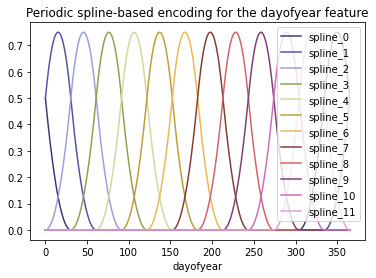

In [24]:

year_df = pd.DataFrame(
    np.linspace(0, 365, 1000).reshape(-1, 1),
    columns=[DAYOFYEAR],
)
splines = periodic_spline_transformer(365, n_splines=12, degree=2).fit_transform(year_df)
splines_df = pd.DataFrame(
    splines,
    columns=[f"spline_{i}" for i in range(splines.shape[1])],
)
pd.concat([year_df, splines_df], axis="columns").plot(x=DAYOFYEAR, cmap=plt.cm.tab20b)
_ = plt.title(f"Periodic spline-based encoding for the {DAYOFYEAR} feature")

In [25]:
# https://www.kaggle.com/samuelcortinhas/tps-jan-22-quick-eda-hybrid-model/notebook
def unofficial_holiday(df):
    countries = {'Finland': 1, 'Norway': 2, 'Sweden': 3}
    stores = {'KaggleMart': 1, 'KaggleRama': 2}
    products = {'Kaggle Mug': 1,'Kaggle Hat': 2, 'Kaggle Sticker': 3}
    
    # load holiday info.
#     hol_path = '../input/public-and-unofficial-holidays-nor-fin-swe-201519/holidays.csv'
    hol_path = datapath/'holidays.csv'
    holiday = pd.read_csv(hol_path)
    
    fin_holiday = holiday.loc[holiday.country == 'Finland']
    swe_holiday = holiday.loc[holiday.country == 'Sweden']
    nor_holiday = holiday.loc[holiday.country == 'Norway']
    df['fin holiday'] = df.date.isin(fin_holiday.date).astype(int)
    df['swe holiday'] = df.date.isin(swe_holiday.date).astype(int)
    df['nor holiday'] = df.date.isin(nor_holiday.date).astype(int)
    df['holiday'] = np.zeros(df.shape[0]).astype(int)
    df.loc[df.country == 'Finland', 'holiday'] = df.loc[df.country == 'Finland', 'fin holiday']
    df.loc[df.country == 'Sweden', 'holiday'] = df.loc[df.country == 'Sweden', 'swe holiday']
    df.loc[df.country == 'Norway', 'holiday'] = df.loc[df.country == 'Norway', 'nor holiday']
    df.drop(['fin holiday', 'swe holiday', 'nor holiday'], axis=1, inplace=True)
    return df

In [26]:
# BUID calendar columns
MONTH_COLUMNS = []
WEEKOFYEAR_COLUMNS = []
DAYOFYEAR_COLUMNS = []
WEEKDAY_COLUMNS = []

for x in [MONTH,WEEKOFYEAR,DAYOFYEAR,WEEKDAY]:
    for y in [f'mug_{x}', f'hat_{x}', f'stick_{x}']:
        if x == MONTH:
            MONTH_COLUMNS.append(y)
        if x == WEEKOFYEAR:
            WEEKOFYEAR_COLUMNS.append(y)
        if x == DAYOFYEAR:
            DAYOFYEAR_COLUMNS.append(y)
        if x == WEEKDAY:
            WEEKDAY_COLUMNS.append(y)


In [27]:
def fourier_features(index, freq, order):
    time = np.arange(len(index), dtype=np.float32)
    k = 2 * np.pi * (1 / freq) * time
    features = {}
    for i in range(1, order + 1):
        features.update({
            f"sin_{freq}_{i}": np.sin(i * k),
            f"cos_{freq}_{i}": np.cos(i * k),
        })
    return pd.DataFrame(features, index=index)

def get_basic_ts_features(df):
#     gdp_df = pd.read_csv('../input/gdp-20152019-finland-norway-and-sweden/GDP_data_2015_to_2019_Finland_Norway_Sweden.csv')
    gdp_df = pd.read_csv(datapath/'GDP_data_2015_to_2019_Finland_Norway_Sweden.csv')
    gdp_df.set_index('year', inplace=True)
#     gdp_exponent = 1.2121103201489674 # see https://www.kaggle.com/ambrosm/tpsjan22-03-linear-model for an explanation
    def get_gdp(row):
        country = 'GDP_' + row.country
        return gdp_df.loc[row.date.year, country] #**gdp_exponent

    # Apply GDP log
    df['gdp'] = np.log1p(df.apply(get_gdp, axis=1))
    
#     # Split GDP by country (for linear model)
#     df['fin_gdp']=np.where(df['country'] == 'Finland', df['gdp'], 0)
#     df['nor_gdp']=np.where(df['country'] == 'Norway', df['gdp'], 0)
#     df['swe_gdp']=np.where(df['country'] == 'Sweden', df['gdp'], 0)
    
#     # Drop column
#     df=df.drop(['gdp'],axis=1)
    
    # one-hot encoding should be used. linear model should not learn this as numeric value
#     df[YEAR] = df[DATE].dt.year
#     df[MONTH] = df[DATE].dt.month
#     df[WEEKOFYEAR] = df[DATE].dt.isocalendar().week
#     df[DAYOFYEAR] = df[DATE].dt.dayofyear
#     df[WEEKDAY] = df[DATE].dt.weekday
#     df[DAY] = df[DATE].dt.day # day in month
#     df[DAYOFMONTH] = df[DATE].dt.days_in_month
#     df[DAYOFWEEK] = df[DATE].dt.dayofweek
#     df[MONTH] = df[DATE].dt.month # Min SMAPE: 4.005319478790032
#     df[QUARTER] = df.date.dt.quarter

    df['wd0'] = df[DATE].dt.weekday == 0 # + Monday
    df['wd1'] = df[DATE].dt.weekday == 1 # Tuesday
    df['wd2'] = df[DATE].dt.weekday == 2
    df['wd3'] = df[DATE].dt.weekday == 3
    df['wd4'] = df[DATE].dt.weekday == 4 # + Friday
    df['wd56'] = df[DATE].dt.weekday >= 5 # + Weekend

#     df[f'mug_wd4'] = np.where(df['product'] == 'Kaggle Mug', df[f'wd4'], False)
#     df[f'mug_wd56'] = np.where(df['product'] == 'Kaggle Mug', df[f'wd56'], False)
#     df[f'hat_wd4'] = np.where(df['product'] == 'Kaggle Hat', df[f'wd4'], False)
#     df[f'hat_wd56'] = np.where(df['product'] == 'Kaggle Hat', df[f'wd56'], False)
#     df[f'stick_wd4'] = np.where(df['product'] == 'Kaggle Sticker', df[f'wd4'], False)
#     df[f'stick_wd56'] = np.where(df['product'] == 'Kaggle Sticker', df[f'wd56'], False)
#     df = df.drop(columns=[f'wd4', f'wd56'])
    # 4 seasons
#     df['season'] = ((df[DATE].dt.month % 12 + 3) // 3).map({1:'DJF', 2: 'MAM', 3:'JJA', 4:'SON'})

    return df

def feature_splines(df):
    # one-hot encoding should be used. linear model should not learn this as numeric value
#     df[MONTH] = df[DATE].dt.month
#     df[WEEKOFYEAR] = df[DATE].dt.isocalendar().week
    df[WEEKDAY] = df[DATE].dt.weekday
#     df[DAYOFYEAR] = df[DATE].dt.dayofyear
    
    dayofyear_splines = periodic_spline_transformer(365, n_splines=9, degree=2).fit_transform(df[DATE].dt.dayofyear.values.reshape(-1, 1))
    splines_df = pd.DataFrame(
        dayofyear_splines,
        columns=[f"spline_{i}" for i in range(dayofyear_splines.shape[1])],
    )
    for i in range(dayofyear_splines.shape[1]):
        df[f'mug_{DAYOFYEAR}{i}'] = np.where(df['product'] == 'Kaggle Mug', splines_df[f"spline_{i}"], 0.)
        df[f'hat_{DAYOFYEAR}{i}'] = np.where(df['product'] == 'Kaggle Hat', splines_df[f"spline_{i}"], 0.)
        df[f'stick_{DAYOFYEAR}{i}'] = np.where(df['product'] == 'Kaggle Sticker', splines_df[f"spline_{i}"], 0.)
#         df[f'fin_{DAYOFYEAR}{i}'] = np.where(df['country'] == 'Finland', splines_df[f"spline_{i}"], 0.)
#         df[f'nor_{DAYOFYEAR}{i}'] = np.where(df['country'] == 'Norway', splines_df[f"spline_{i}"], 0.)
#         df[f'swe_{DAYOFYEAR}{i}'] = np.where(df['country'] == 'Sweden', splines_df[f"spline_{i}"], 0.)

#     weekofyear_splines = periodic_spline_transformer(52, n_splines=2, degree=2).fit_transform(df[DATE].dt.isocalendar().week.values.astype(np.float64).reshape(-1,1))
#     splines_df = pd.DataFrame(
#         weekofyear_splines,
#         columns=[f"spline_{i}" for i in range(weekofyear_splines.shape[1])],
#     )
#     for i in range(weekofyear_splines.shape[1]):
#         df[f'weekofyear_{WEEKOFYEAR}{i}'] = splines_df[f"spline_{i}"]
#         df[f'hat_{WEEKOFYEAR}{i}'] = np.where(df['product'] == 'Kaggle Hat', splines_df[f"spline_{i}"], 0)
#         df[f'stick_{WEEKOFYEAR}{i}'] = np.where(df['product'] == 'Kaggle Sticker', splines_df[f"spline_{i}"], 0)
#     df[f'mug_{MONTH}'] = np.where(df['product'] == 'Kaggle Mug', df[MONTH], 0)
#     df[f'mug_{WEEKOFYEAR}'] = np.where(df['product'] == 'Kaggle Mug', df[WEEKOFYEAR], 0)
#     df[f'mug_{DAYOFYEAR}'] = np.where(df['product'] == 'Kaggle Mug', df[DAYOFYEAR], 0)
#     df[f'mug_{WEEKDAY}'] = np.where(df['product'] == 'Kaggle Mug', df[WEEKDAY], 0)
#     df[f'hat_{MONTH}'] = np.where(df['product'] == 'Kaggle Hat', df[MONTH], 0)
#     df[f'hat_{WEEKOFYEAR}'] = np.where(df['product'] == 'Kaggle Hat', df[WEEKOFYEAR], 0)
#     df[f'hat_{DAYOFYEAR}'] = np.where(df['product'] == 'Kaggle Hat', df[DAYOFYEAR], 0)
#     df[f'hat_{WEEKDAY}'] = np.where(df['product'] == 'Kaggle Hat', df[WEEKDAY], 0)
#     df[f'stick_{MONTH}'] = np.where(df['product'] == 'Kaggle Sticker', df[MONTH], 0)
#     df[f'stick_{WEEKOFYEAR}'] = np.where(df['product'] == 'Kaggle Sticker', df[WEEKOFYEAR], 0)
#     df[f'stick_{DAYOFYEAR}'] = np.where(df['product'] == 'Kaggle Sticker', df[DAYOFYEAR], 0)
#     df[f'stick_{WEEKDAY}'] = np.where(df['product'] == 'Kaggle Sticker', df[WEEKDAY], 0)

#     df = df.drop(columns=[DAYOFYEAR]) #MONTH, WEEKOFYEAR, WEEKDAY

    return df

def feature_periodic(df):
    # 21 days cyclic for lunar
    # 21 4.244872419046287 31 4.23870 37 4.2359085545955875 47 4.24590382934362 39 4.236812122257115 
    # 35 4.2358561209794665 33 4.237682217183017 36 4.230652791910613 3 4.241000488616227 4.23833321067532
    #[7, 14, 21, 28, 30, 31, 91] range(1, 32, 4) range(1,3,1)[1,2,4]
    # Long term periodic
    dayofyear = df.date.dt.dayofyear
    j=-36
    for k in [2]:
        df = pd.concat([df,
                        pd.DataFrame({
                            f"sin{k}": np.sin((dayofyear+j) / 365 * 1 * math.pi * k),
                            f"cos{k}": np.cos((dayofyear+j) / 365 * 1 * math.pi * k),
                                     })], axis=1)
        # Products
        df[f'mug_sin{k}'] = np.where(df['product'] == 'Kaggle Mug', df[f'sin{k}'], 0)
        df[f'mug_cos{k}'] = np.where(df['product'] == 'Kaggle Mug', df[f'cos{k}'], 0)
        df[f'hat_sin{k}'] = np.where(df['product'] == 'Kaggle Hat', df[f'sin{k}'], 0)
        df[f'hat_cos{k}'] = np.where(df['product'] == 'Kaggle Hat', df[f'cos{k}'], 0)
        df[f'stick_sin{k}'] = np.where(df['product'] == 'Kaggle Sticker', df[f'sin{k}'], 0)
        df[f'stick_cos{k}'] = np.where(df['product'] == 'Kaggle Sticker', df[f'cos{k}'], 0)
        df = df.drop(columns=[f'sin{k}', f'cos{k}'])

    # Short term Periodic
    weekday = df.date.dt.weekday
    df[f'weekly_sin'] = np.sin((1 / 7) * 2 * math.pi*(weekday+1)) #+
    df[f'weekly_cos'] = np.cos((1 / 7) * 2 * math.pi*(weekday+1)) #+
    df[f'semiweekly_sin'] = np.sin((1 / 7) * 4 * math.pi*(dayofyear-1.5)) #+ ⁅sin(1/7 𝜋⋅4(𝑥−2))⁆
    df[f'semiweekly_cos'] = np.cos((1 / 7) * 4 * math.pi*(dayofyear-1.5)) #+ ⁅cos(1/7 𝜋⋅4𝑥)⁆
    
    df[f'fin_weekly_sin'] = np.where(df['country'] == 'Finland', df[f'weekly_sin'], 0)
    df[f'fin_weekly_cos'] = np.where(df['country'] == 'Finland', df[f'weekly_cos'], 0)
    df[f'nor_weekly_sin'] = np.where(df['country'] == 'Norway', df[f'weekly_sin'], 0)
    df[f'nor_weekly_cos'] = np.where(df['country'] == 'Norway', df[f'weekly_cos'], 0)
    df[f'swe_weekly_sin'] = np.where(df['country'] == 'Sweden', df[f'weekly_sin'], 0)
    df[f'swe_weekly_cos'] = np.where(df['country'] == 'Sweden', df[f'weekly_cos'], 0)
    
    df[f'mug_weekly_sin'] = np.where(df['product'] == 'Kaggle Mug', df[f'weekly_sin'], 0)
    df[f'mug_weekly_cos'] = np.where(df['product'] == 'Kaggle Mug', df[f'weekly_cos'], 0)
    df[f'hat_weekly_sin'] = np.where(df['product'] == 'Kaggle Hat', df[f'weekly_sin'], 0)
    df[f'hat_weekly_cos'] = np.where(df['product'] == 'Kaggle Hat', df[f'weekly_cos'], 0)
    df[f'stick_weekly_sin'] = np.where(df['product'] == 'Kaggle Sticker', df[f'weekly_sin'], 0)
    df[f'stick_weekly_cos'] = np.where(df['product'] == 'Kaggle Sticker', df[f'weekly_cos'], 0)
    
    df[f'mug_semiweekly_sin'] = np.where(df['product'] == 'Kaggle Mug', df[f'semiweekly_sin'], 0)
    df[f'mug_semiweekly_cos'] = np.where(df['product'] == 'Kaggle Mug', df[f'semiweekly_cos'], 0)
    df[f'hat_semiweekly_sin'] = np.where(df['product'] == 'Kaggle Hat', df[f'semiweekly_sin'], 0)
    df[f'hat_semiweekly_cos'] = np.where(df['product'] == 'Kaggle Hat', df[f'semiweekly_cos'], 0)
    df[f'stick_semiweekly_sin'] = np.where(df['product'] == 'Kaggle Sticker', df[f'semiweekly_sin'], 0)
    df[f'stick_semiweekly_cos'] = np.where(df['product'] == 'Kaggle Sticker', df[f'semiweekly_cos'], 0)
    
    df = df.drop(columns=['weekly_sin', 'weekly_cos', 'semiweekly_sin', 'semiweekly_cos'])
    
#     df[f'semiannual_sin'] = np.sin(dayofyear / 182.5 * 2 * math.pi)
#     df[f'semiannual_cos'] = np.cos(dayofyear / 182.5 * 2 * math.pi)
    
    return df

def feature_holiday(df):
# Dec Jan
    # End of year
    df = pd.concat([df,
                        pd.DataFrame({f"f-dec{d}":
                                      (df.date.dt.month == 12) & (df.date.dt.day == d) & (df.country == 'Finland')
                                      for d in range(24, 32)}),
                        pd.DataFrame({f"n-dec{d}":
                                      (df.date.dt.month == 12) & (df.date.dt.day == d) & (df.country == 'Norway')
                                      for d in range(24, 32)}),
                        pd.DataFrame({f"s-dec{d}":
                                      (df.date.dt.month == 12) & (df.date.dt.day == d) & (df.country == 'Sweden')
                                      for d in range(24, 32)}),
                        pd.DataFrame({f"f-jan{d}":
                                      (df.date.dt.month == 1) & (df.date.dt.day == d) & (df.country == 'Finland')
                                      for d in range(1, 14)}),
                        pd.DataFrame({f"n-jan{d}":
                                      (df.date.dt.month == 1) & (df.date.dt.day == d) & (df.country == 'Norway')
                                      for d in range(1, 10)}),
                        pd.DataFrame({f"s-jan{d}":
                                      (df.date.dt.month == 1) & (df.date.dt.day == d) & (df.country == 'Sweden')
                                      for d in range(1, 15)})
                       ], axis=1)
        
    # May
    df = pd.concat([df,
                        pd.DataFrame({f"may{d}":
                                      (df.date.dt.month == 5) & (df.date.dt.day == d) 
                                      for d in list(range(1, 10))}),
                        pd.DataFrame({f"may{d}":
                                      (df.date.dt.month == 5) & (df.date.dt.day == d) & 
                                      (df.country == 'Norway')
                                      for d in list(range(18, 28))})
                        ], axis=1)
    
    # June and July 8, 14
    df = pd.concat([df,
                        pd.DataFrame({f"june{d}":
                                      (df.date.dt.month == 6) & (df.date.dt.day == d) & 
                                      (df.country == 'Sweden')
                                      for d in list(range(8, 14))}),
                       ], axis=1)
    # Last Wednesday of June
    wed_june_date = df.date.dt.year.map({2015: pd.Timestamp(('2015-06-24')),
                                         2016: pd.Timestamp(('2016-06-29')),
                                         2017: pd.Timestamp(('2017-06-28')),
                                         2018: pd.Timestamp(('2018-06-27')),
                                         2019: pd.Timestamp(('2019-06-26'))})
    df = pd.concat([df, pd.DataFrame({f"wed_june{d}": 
                                      (df.date - wed_june_date == np.timedelta64(d, "D")) & 
                                      (df.country != 'Norway')
                                      for d in list(range(-4, 6))})], axis=1)

    # First Sunday of November
    sun_nov_date = df.date.dt.year.map({2015: pd.Timestamp(('2015-11-1')),
                                         2016: pd.Timestamp(('2016-11-6')),
                                         2017: pd.Timestamp(('2017-11-5')),
                                         2018: pd.Timestamp(('2018-11-4')),
                                         2019: pd.Timestamp(('2019-11-3'))})
    df = pd.concat([df, pd.DataFrame({f"sun_nov{d}":
                                      (df.date - sun_nov_date == np.timedelta64(d, "D")) & (df.country == 'Norway')
                                      for d in list(range(0, 9))})], axis=1)
    # First half of December (Independence Day of Finland, 6th of December)
    df = pd.concat([df, pd.DataFrame({f"dec{d}":
                                      (df.date.dt.month == 12) & (df.date.dt.day == d) & (df.country == 'Finland')
                                      for d in list(range(6, 14))})], axis=1)
    # Easter April
    easter_date = df.date.apply(lambda date: pd.Timestamp(easter.easter(date.year)))
    df = pd.concat([df, pd.DataFrame({f"easter{d}":
                                      (df.date - easter_date == np.timedelta64(d, "D"))
                                      for d in list(range(-2, 11)) + list(range(40, 48)) + list(range(50, 59))})], axis=1)
    return df

In [28]:
def temporal_engineering(df):
    df = get_basic_ts_features(df)
    df = feature_splines(df)
    df = feature_periodic(df)
    df = feature_holiday(df)
    df = unofficial_holiday(df)
    return df.copy()

In [29]:
# # Old feature engineering function

# def temporal_engineering(df):
#     '''
#     Function inspired by / borrowing from @teckmengwong and @ambrosm to create time features that will
#     capture seasonality.
#     '''
    
# #     df[YEAR] = df[DATE].dt.year
#     df['month'] = df['date'].dt.month
# #     df['week'] = df['date'].dt.week # not used by Teck Meng Wong
# #     df['day'] = df['date'].dt.day # not used by Teck Meng Wong
# #     df['day_of_year'] = df['date'].dt.dayofyear # not used by Teck Meng Wong
# #     df['day_of_month'] = df['date'].dt.days_in_month # not used by Teck Meng Wong
# #     df['day_of_week'] = df['date'].dt.dayofweek # not used by Teck Meng Wong
# #    df['weekday'] = df['date'].dt.weekday # not used by Teck Meng Wong
#     # Teck Meng Wong mapped the integers to first-letters in triplets
#     # I'm leaving it as integers, where winter=1, spring=2, summer=3, fall=4
#     df['season'] = ((df['date'].dt.month % 12 + 3) // 3) #.map({1:'DJF', 2: 'MAM', 3:'JJA', 4:'SON'})
# #     df['month'] = df['month'].apply(lambda x: calendar.month_abbr[x])

#     df['wd4'] = df['date'].dt.weekday == 4
#     df['wd56'] = df['date'].dt.weekday >= 5
# #     df['wd6'] = df['date'].dt.weekday >= 6
# #     df.loc[(df.date.dt.year != 2016) & (df.date.dt.month >=3), 'day_of_year'] += 1 # fix for leap years
    
#     # 21 days cyclic for lunar
#     dayofyear = df.date.dt.dayofyear # for convenience
    
#     # here he's creating Fourier features
#     for k in range(1, 32, 4):
#         df[f'sin{k}'] = np.sin(dayofyear / 365 * 2 * math.pi * k)
#         df[f'cos{k}'] = np.cos(dayofyear / 365 * 2 * math.pi * k)
#         df[f'finland_sin{k}'] = np.where(df['country'] == 'Finland', df[f'sin{k}'], 0)
#         df[f'finland_cos{k}'] = np.where(df['country'] == 'Finland', df[f'cos{k}'], 0)
#         df[f'norway_sin{k}'] = np.where(df['country'] == 'Norway', df[f'sin{k}'], 0)
#         df[f'norway_cos{k}'] = np.where(df['country'] == 'Norway', df[f'cos{k}'], 0)
#         df[f'store_sin{k}'] = np.where(df['store'] == 'KaggleMart', df[f'sin{k}'], 0)
#         df[f'store_cos{k}'] = np.where(df['store'] == 'KaggleMart', df[f'cos{k}'], 0)
#         df[f'mug_sin{k}'] = np.where(df['product'] == 'Kaggle Mug', df[f'sin{k}'], 0)
#         df[f'mug_cos{k}'] = np.where(df['product'] == 'Kaggle Mug', df[f'cos{k}'], 0)
#         df[f'sticker_sin{k}'] = np.where(df['product'] == 'Kaggle Sticker', df[f'sin{k}'], 0)
#         df[f'sticker_cos{k}'] = np.where(df['product'] == 'Kaggle Sticker', df[f'cos{k}'], 0)
    
# #     df[f'semiweekly_sin'] = np.sin(dayofyear / 365 * 2 * math.pi * 14)
# #     df[f'semiweekly_cos'] = np.cos(dayofyear / 365 * 2 * math.pi * 14)
# #     df[f'lunar_sin'] = np.sin(dayofyear / 365 * 2 * math.pi * 21)
# #     df[f'lunar_cos'] = np.cos(dayofyear / 365 * 2 * math.pi * 21)
#     df[f'season_sin'] = np.sin(dayofyear / 365 * 2 * math.pi * 91.5)
#     df[f'season_cos'] = np.cos(dayofyear / 365 * 2 * math.pi * 91.5)
# #     df = pd.concat([df, pd.DataFrame({f'fin{ptr[1]}':
# #                                       (df.date == pd.Timestamp(ptr[0])) & (df.country == 'Finland')
# #                                       for ptr in holidays.Finland(years = [2015,2016,2017,2018,2019]).items()})], axis=1)
# #     df = pd.concat([df, pd.DataFrame({f'nor{ptr[1]}':
# #                                       (df.date == pd.Timestamp(ptr[0])) & (df.country == 'Norway')
# #                                       for ptr in holidays.Norway(years = [2015,2016,2017,2018,2019]).items()})], axis=1)
# #     df = pd.concat([df, pd.DataFrame({f'swe{ptr[1]}':
# #                                       (df.date == pd.Timestamp(ptr[0])) & (df.country == 'Sweden')
# #                                       for ptr in holidays.Sweden(years = [2015,2016,2017,2018,2019]).items()})], axis=1)

#     # End of year
#     # Dec - teckmengwong
#     for d in range(24, 32):
#         df[f"dec{d}"] = (df.date.dt.month == 12) & (df.date.dt.day == d)
#     # I'm unsure of the logic of only doing this for Norway
#     for d in range(24, 32):
#         df[f"n-dec{d}"] = (df.date.dt.month == 12) & (df.date.dt.day == d) & (df.country == 'Norway')
    
#     # not sure why he's using different date ranges for each country here
#     # Jan - teckmengwong
#     for d in range(1, 14):
#         df[f"f-jan{d}"] = (df.date.dt.month == 1) & (df.date.dt.day == d) & (df.country == 'Finland')
#     for d in range(1, 10):
#         df[f"n-jan{d}"] = (df.date.dt.month == 1) & (df.date.dt.day == d) & (df.country == 'Norway')
#     for d in range(1, 15):
#         df[f"s-jan{d}"] = (df.date.dt.month == 1) & (df.date.dt.day == d) & (df.country == 'Sweden')
    
    
#     # May - tekcmengwong
#     for d in list(range(1, 10)): # May Day and after, I guess
#         df[f"may{d}"] = (df.date.dt.month == 5) & (df.date.dt.day == d)
#     for d in list(range(19, 26)):
#         df[f"may{d}"] = (df.date.dt.month == 5) & (df.date.dt.day == d) & (df.country == 'Norway')
#     # June 
#     for d in list(range(8, 14)):
#         df[f"june{d}"] = (df.date.dt.month == 6) & (df.date.dt.day == d) & (df.country == 'Sweden')
    
#     #Swedish Rock Concert - teckmengwong
#     #Jun 3, 2015 – Jun 6, 2015
#     #Jun 8, 2016 – Jun 11, 2016
#     #Jun 7, 2017 – Jun 10, 2017
#     #Jun 6, 2018 – Jun 10, 2018
#     #Jun 5, 2019 – Jun 8, 2019
#     swed_rock_fest  = df.date.dt.year.map({2015: pd.Timestamp(('2015-06-6')),
#                                          2016: pd.Timestamp(('2016-06-11')),
#                                          2017: pd.Timestamp(('2017-06-10')),
#                                          2018: pd.Timestamp(('2018-06-10')),
#                                          2019: pd.Timestamp(('2019-06-8'))})

#     df = pd.concat([df, pd.DataFrame({f"swed_rock_fest{d}":
#                                       (df.date - swed_rock_fest == np.timedelta64(d, "D")) & (df.country == 'Sweden')
#                                       for d in list(range(-3, 3))})], axis=1)

    
#     # Last Wednesday of June - teckmengwong
#     wed_june_date = df.date.dt.year.map({2015: pd.Timestamp(('2015-06-24')),
#                                          2016: pd.Timestamp(('2016-06-29')),
#                                          2017: pd.Timestamp(('2017-06-28')),
#                                          2018: pd.Timestamp(('2018-06-27')),
#                                          2019: pd.Timestamp(('2019-06-26'))})
#     for d in list(range(-4, 6)):
#         df[f"wed_june{d}"] = (df.date - wed_june_date == np.timedelta64(d, "D")) & (df.country != 'Norway')
        
#     # First Sunday of November - teckmengwong
#     sun_nov_date = df.date.dt.year.map({2015: pd.Timestamp(('2015-11-1')),
#                                          2016: pd.Timestamp(('2016-11-6')),
#                                          2017: pd.Timestamp(('2017-11-5')),
#                                          2018: pd.Timestamp(('2018-11-4')),
#                                          2019: pd.Timestamp(('2019-11-3'))})
#     df = pd.concat([df, pd.DataFrame({f"sun_nov{d}":
#                                       (df.date - sun_nov_date == np.timedelta64(d, "D")) & (df.country == 'Norway')
#                                       for d in list(range(0, 9))})], axis=1)
    
#     # First half of December (Independence Day of Finland, 6th of December) -teckmengwong
#     df = pd.concat([df, pd.DataFrame({f"dec{d}":
#                                       (df.date.dt.month == 12) & (df.date.dt.day == d) & (df.country == 'Finland')
#                                       for d in list(range(6, 14))})], axis=1)
    
#     # Easter -teckmengwong
#     easter_date = df.date.apply(lambda date: pd.Timestamp(easter.easter(date.year)))
#     df = pd.concat([df, pd.DataFrame({f"easter{d}":
#                                       (df.date - easter_date == np.timedelta64(d, "D"))
#                                       for d in list(range(-2, 11)) + list(range(40, 48)) + list(range(50, 59))})], axis=1)
    
#     return df

In [30]:
temporal_all_df = temporal_engineering(all_df)

In [31]:
temporal_all_df

,row_id,date,country,store,product,num_sold,gdp,wd0,wd1,wd2,...,easter50,easter51,easter52,easter53,easter54,easter55,easter56,easter57,easter58,holiday
0,0,2015-01-01,Finland,KaggleMart,Kaggle Mug,329.0,5.461456,False,False,False,...,False,False,False,False,False,False,False,False,False,1
1,1,2015-01-01,Finland,KaggleMart,Kaggle Hat,520.0,5.461456,False,False,False,...,False,False,False,False,False,False,False,False,False,1
2,2,2015-01-01,Finland,KaggleMart,Kaggle Sticker,146.0,5.461456,False,False,False,...,False,False,False,False,False,False,False,False,False,1
3,3,2015-01-01,Finland,KaggleRama,Kaggle Mug,572.0,5.461456,False,False,False,...,False,False,False,False,False,False,False,False,False,1
4,4,2015-01-01,Finland,KaggleRama,Kaggle Hat,911.0,5.461456,False,False,False,...,False,False,False,False,False,False,False,False,False,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6565,32863,2019-12-31,Sweden,KaggleMart,Kaggle Hat,NaN,6.282042,False,True,False,...,False,False,False,False,False,False,False,False,False,0
6566,32864,2019-12-31,Sweden,KaggleMart,Kaggle Sticker,NaN,6.282042,False,True,False,...,False,False,False,False,False,False,False,False,False,0
6567,32865,2019-12-31,Sweden,KaggleRama,Kaggle Mug,NaN,6.282042,False,True,False,...,False,False,False,False,False,False,False,False,False,0
6568,32866,2019-12-31,Sweden,KaggleRama,Kaggle Hat,NaN,6.282042,False,True,False,...,False,False,False,False,False,False,False,False,False,0


At this point, the `temporal_all_df` DataFrame contains all the time features for both the training and testing sets.
* **Todo**: consider not only adding in holidays from `holidays`, but also borrowing ideas from the AmbrosM Linear notebook too (which creates fewer features, populating them instead with temporal distances from the selected holidays).

### Target Transformation
Now, I'll do the target transformation proposed by @AmbrosM. (I'll do it to the non-encoded DataFrame too, for testing with Prophet and NeuralProphet later.)

In [32]:
for df in [temporal_all_df]:
    df['target'] = np.log(df['num_sold'] / df['gdp']**gdp_exponent)

In [33]:
# encoded_all_df['target'] = np.log(encoded_all_df['num_sold'] / (encoded_all_df['gdp']**gdp_exponent))

In [34]:
temporal_all_df

,row_id,date,country,store,product,num_sold,gdp,wd0,wd1,wd2,...,easter51,easter52,easter53,easter54,easter55,easter56,easter57,easter58,holiday,target
0,0,2015-01-01,Finland,KaggleMart,Kaggle Mug,329.0,5.461456,False,False,False,...,False,False,False,False,False,False,False,False,1,3.738239
1,1,2015-01-01,Finland,KaggleMart,Kaggle Hat,520.0,5.461456,False,False,False,...,False,False,False,False,False,False,False,False,1,4.196010
2,2,2015-01-01,Finland,KaggleMart,Kaggle Sticker,146.0,5.461456,False,False,False,...,False,False,False,False,False,False,False,False,1,2.925788
3,3,2015-01-01,Finland,KaggleRama,Kaggle Mug,572.0,5.461456,False,False,False,...,False,False,False,False,False,False,False,False,1,4.291321
4,4,2015-01-01,Finland,KaggleRama,Kaggle Hat,911.0,5.461456,False,False,False,...,False,False,False,False,False,False,False,False,1,4.756724
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6565,32863,2019-12-31,Sweden,KaggleMart,Kaggle Hat,NaN,6.282042,False,True,False,...,False,False,False,False,False,False,False,False,0,NaN
6566,32864,2019-12-31,Sweden,KaggleMart,Kaggle Sticker,NaN,6.282042,False,True,False,...,False,False,False,False,False,False,False,False,0,NaN
6567,32865,2019-12-31,Sweden,KaggleRama,Kaggle Mug,NaN,6.282042,False,True,False,...,False,False,False,False,False,False,False,False,0,NaN
6568,32866,2019-12-31,Sweden,KaggleRama,Kaggle Hat,NaN,6.282042,False,True,False,...,False,False,False,False,False,False,False,False,0,NaN


### Label Encoding

I'm going to encapsulate this in a function so that it can be invoked just-in-time, in the hopes of avoiding confusions with DataFrames.

In [35]:
def label_encoder(df):
    from sklearn.preprocessing import LabelEncoder
    features = ['country', 'product', 'store']
    le_dict = {feature: LabelEncoder().fit(orig_train_df[feature]) for feature in features}
    enc_df = df.copy()
    for feature in features:
        enc_df[feature] = le_dict[feature].transform(df[feature])
    return le_dict, enc_df

In [36]:
# for key in le_dict.keys():
#     print(f"Values for key {key} are {le_dict[key].inverse_transform(range(len(le_dict[key].values())))}")#"
# print(le_dict['country'].inverse_transform([0,1,2]))
# print(le_dict['product'].inverse_transform([0,1,2]))
# print(le_dict['store'].inverse_transform([0,1]))

```
['Finland' 'Norway' 'Sweden']
['Kaggle Hat' 'Kaggle Mug' 'Kaggle Sticker']
['KaggleMart' 'KaggleRama']
```

Now, we'll do the encoding.

At this point, the `encoded_all_df` can be used -- perhaps with a call to `LabelEncoder.inverse_transform` -- to recover the "original" data when necessary (e.g. for feeding it into Prophet and NeuralProphet)

In [37]:
# encoded_all_df = label_encoder(temporal_all_df)

### Pseudolabeling

I'm not going to try this right now, but I may return to it later -- I note that Teck Meng Wong had some good results with it.

In [38]:
# # here's teck meng wong's implementation -- see the notebook for the constants
# df_pseudolabels = pd.read_csv(PSEUDO_DIR, index_col=ID)
# df_pseudolabels[DATE] = pd.to_datetime(test_df[DATE])
# df_pseudolabels.to_csv("pseudo_labels_v0.csv", index=True)
# # if PSEUDO_LABEL:
#     # df_pseudolabels = df_pseudolabels.set_index([DATE]).sort_index()
# test_df[column_y] = df_pseudolabels[column_y].astype(np.float64)
# train_df = pd.concat([train_df, test_df], axis=0)

### Data Splitting, Modification

Now that the preprocessing is done, I'm going to split the data back into the train and test sets; then, I'll create a view on the dataframes that omits the year. The year-less dataframes will be suitable for residual learning.

In [39]:
# all_df = encoded_all_df.drop(columns=['num_sold', 'row_id'])
all_df = temporal_all_df.drop(columns=['row_id']) # writing over the previous version of `all_df`

In [40]:
tv_df = all_df[:len(orig_train_df)] # training and validation sets -- still not encoded
test_df = all_df[len(orig_train_df):] # still not encoded


In [41]:
# train_df = encoded_all_df.iloc[np.where(encoded_all_df['date'] < '2019-01-01'), :]
# test_df = encoded_all_df[[np.where(encoded_all_df['date'] > '2018-12-31')]]

# encoded_tv_df = encoded_all_df.drop(columns=['row_id'])[:len(orig_train_df)]
# encoded_test_df = encoded_all_df.drop(columns=['row_id'])[len(orig_train_df):]

# valid_df = tv_df[tv_df['date'] > '2017-12-31']
# train_df = tv_df[tv_df['date'] <= '2017-12-31']

# train_and_valid_residual_df = train_and_valid_df.drop(columns=['date'])
# test_residual_df = test_df.drop(columns=['date'])

# len(valid_df) + len(train_df) == len(tv_df)

# encoded_tv_df

# Training

### Forecasting Models Prep
First, we'll set up functions to handle the training of forecasting models which will discern trends, and which may -- or may not -- yield insights concerning seasonality. While the Scikit-Learn models will be able to share a single trainer function, the Prophet and NeuralProphet models have subtly different expectations of their data, and as such will require separate handling.

In [42]:
from sklearn.linear_model import Ridge, HuberRegressor, LinearRegression, Lasso
from sklearn.neural_network import MLPRegressor
from prophet import Prophet
from neuralprophet import NeuralProphet
# earth? wouldn't install via pip on my machine at first

In [43]:
import torch
import torch.nn as nn
from torch.nn.utils import weight_norm
from skorch import NeuralNetRegressor
import torch.optim as optim

#### (Preprepared Preds)

The next cell contains code to import already-existing predictions -- but I think it's better to centralize the code that produces them here, and will comment out the import code for now.

In [44]:
# prophet_trainset = load(predpath/'20220121_prophet_baseline_trainset.joblib')

# neural_trainset = load(predpath/'20220121_neuralprophet_baseline_trainset.joblib')
# neural_test_preds = load(predpath/'20220121_neuralprophet_baseline_testset.joblib')

# ridge_tv_preds = load(predpath/'20210121_ridge_baseline_trainset_preds.joblib')
# ridge_test_preds = load(predpath/'20220121_ridge_testset_preds.joblib')

And this cell would handle the parsing

In [45]:
# neural_tv_preds = neural_trainset['prophet_forecast']
# prophet_tv_preds = prophet_trainset['prophet_forecast']

# neural_train_preds = neural_tv_preds[:train_length]
# neural_valid_preds = neural_tv_preds[train_length:]

# prophet_train_preds = prophet_tv_preds[:train_length]
# prophet_valid_preds = prophet_tv_preds[train_length:]

# train_length = len(neural_trainset[neural_trainset['date'] <= '2017-12-31'])

# ridge_train_preds = ridge_tv_preds[:train_length]
# ridge_valid_preds = ridge_tv_preds[train_length:]

#### Scikit-Learn Linear Models Prep

Linear models from Scikit-Learn seemingly require that datetime data be converted to numerics.

In [46]:
# train_linear_df = train_df.copy()
# valid_linear_df = valid_df.copy()
# test_linear_df = test_df.copy()
# tv_linear_df = tv_df.copy()



### Forecasters

#### Hyperparameters
I'll hard-code them for now, but in the future may Optuna them. May want to create a dict of all the kwargs to be used for all the models, with the model names as keys

In [47]:
prophet_kwargs = {
    'growth':'linear',
#     'holidays':holidays_train, # will add this in-function
    'n_changepoints':10,
    'changepoint_range':0.4,
    'yearly_seasonality':True,
    'weekly_seasonality':True,
    'daily_seasonality':False,
    'seasonality_mode':'additive',
    'seasonality_prior_scale':25,
    'holidays_prior_scale':100,
    'changepoint_prior_scale':0.01,
    'interval_width':0.5,
    'uncertainty_samples':False
}

neuralprophet_kwargs = {
    'growth':'linear',
    'n_changepoints':10,
    'changepoints_range':0.4,
    'trend_reg':1,
    'trend_reg_threshold':False,
    'yearly_seasonality':True,
    'weekly_seasonality':True,
    'daily_seasonality':False,
    'seasonality_mode':'additive',
    'seasonality_reg':1,
    'n_forecasts':365,
    'normalize':'off'
}

# for pytorch / skorch
device = 'cuda' if torch.cuda.is_available() else 'cpu'

tcn_kwargs = {
#     'module': estimator, # will be handled at-call
#     'criterion': nn.MSELoss, # consider enhancement here
#     "lr": 0.01, # default is 0.01
#     'optimizer':Adam,
#     'max_epochs':10, # default is 10
#     'device': 'cpu'#device,
    
}

tcn_skorch_kwargs = {
    'module__num_inputs':1,
    'module__num_channels':[10] * 11,
    'module__output_sz':1, #2 * samples_per_hour,
    'module__kernel_size':5,
    'module__dropout':0.0,
    'max_epochs':60, # 60,
    'batch_size':256,
    'lr':2e-3,
    'optimizer':torch.optim.Adam,
    'train_split':None,
}

mlp_skorch_kwargs = {
    'module__n_inputs': tv_df.shape[1],
    'module__hidden_units': 200, 
    'module__dropout': 0.2,
    'max_epochs':25, # 60,
    'batch_size':256,
    'lr':2e-3,
    'optimizer':torch.optim.Adam,
    'train_split':None,
}


# model_params['hyperparams'] = str(neuralprophet_kwargs)
# model_params['holiday_source'] = 'Prophet builtin for each country'

In [48]:
tv_df.shape

(26298, 208)

In [49]:
best_xgboost_params = load(studypath/'optuna_xgboost_study-20220126213551.joblib').best_trial.params
best_xgboost_params['max_depth'] = best_xgboost_params['depth']
del best_xgboost_params['depth']
best_xgboost_params

{'n_estimators': 4207,
 'learning_rate': 0.05378597302351865,
 'reg_alpha': 0.0067949392113948815,
 'reg_lambda': 0.04865823628931899,
 'subsample': 0.212875760245356,
 'min_child_weight': 6.997692447967251,
 'colsample_bytree': 0.9824893256584818,
 'gamma': 0.10395228539921328,
 'max_depth': 5}

In [50]:
best_catboost_params = load(studypath/'optuna_catboost_study-20220127082356.joblib').best_trial.params
best_catboost_params['max_depth'] = best_catboost_params['depth']
del best_catboost_params['depth']
best_catboost_params

{'iterations': 10529,
 'learning_rate': 0.07026263205443048,
 'random_strength': 44,
 'od_wait': 261,
 'reg_lambda': 35.672029887566374,
 'border_count': 57,
 'min_child_samples': 19,
 'leaf_estimation_iterations': 2,
 'max_depth': 3}

In [51]:
best_lightgbm_params = load(studypath/'optuna_lightgbm_study-20220127171126.joblib').best_trial.params
best_lightgbm_params['max_depth'] = best_lightgbm_params['depth']
del best_lightgbm_params['depth']
best_lightgbm_params


{'n_estimators': 6078,
 'learning_rate': 0.03612108919426432,
 'reg_alpha': 0.008631524966022684,
 'reg_lambda': 0.19537138720003774,
 'subsample': 0.9601129223632775,
 'min_child_samples': 24,
 'num_leaves': 235,
 'colsample_bytree': 0.920126987868937,
 'max_depth': 3}

In [52]:
xgboost_params = {
    # universal
#     'tree_method': 'gpu_hist',
#     'predictor': 'gpu_predictor',
#     'eval_metric': ['mae', 'mape', 'rmse'],
#     'sampling_method': 'gradient_based',
#     'grow_policy': 'lossguide',
    
    # best of 500 trials on Optuna
    **best_xgboost_params
}


lightgbm_params = {
    # universal
    'objective': 'mse',
#     'random_state': 42,
    'device_type': 'cpu',
    'n_jobs': -1,
#                 eval_metric='auc',
#     'device_type': 'gpu',
#     'max_bin': 63, # 15 might be even better for GPU perf, but depends on dataset -- see https://lightgbm.readthedocs.io/en/latest/GPU-Performance.html
#     'gpu_use_dp': False,
#     'max_depth': 0,
#     'learning_rate': 0.1,
#     'subsample': .15,
#     'n_estimators': 1500,
    **best_lightgbm_params
}

catboost_params = {
    # universal
#     'task_type':'GPU',
#     'silent':True,
#     'random_state':42,
    
    # from trial 4 (of 5) via Optuna
    **best_catboost_params
}
                

#### Temporal Convolutional Network

Implementation from https://www.kaggle.com/ceshine/pytorch-temporal-convolutional-networks.

In [53]:
# class TemporalBlock(nn.Module):
#     def __init__(self, n_inputs, n_outputs, kernel_size, stride, dilation, padding, dropout=0.2):
#         super(TemporalBlock, self).__init__()
        
#         # this is the first convolutional layer; note that it foregoes padding irrespective of argument
#         self.conv1 = weight_norm(nn.Conv2d(n_inputs, n_outputs, (1, kernel_size),
#                                            stride=stride, padding=0, dilation=dilation))
#         # the padding is then added after the first conv layer
#         self.pad = torch.nn.ZeroPad2d((padding, 0, 0, 0))
#         # this is a very standard choice
#         self.relu = nn.ReLU()
#         self.dropout = nn.Dropout(dropout)
        
#         # the second convolutional layer in the block is identical to the first, but now padding has been added to the input
#         self.conv2 = weight_norm(nn.Conv2d(n_outputs, n_outputs, (1, kernel_size),
#                                            stride=stride, padding=0, dilation=dilation))
        
#         # this simply strings together the above architectural elements, for convenience I guess
#         self.net = nn.Sequential(self.pad, self.conv1, self.relu, self.dropout,
#                                  self.pad, self.conv2, self.relu, self.dropout)
        
#         # if the n_outputs is nonzero, this adds on a final convlutional layer to ensure that we get the desired number of outputs
#         self.downsample = nn.Conv1d(
#             n_inputs, n_outputs, 1) if n_inputs != n_outputs else None
#         self.relu = nn.ReLU()
        
#         # this initializes the weights as specified in the separate weight initialization method, below
#         self.init_weights()

#     def init_weights(self):
#         # this method initializes the weights for the Conv1D and Conv2D layers, plus the Downsample layer (if it's used)
#         self.conv1.weight.data.normal_(0, 0.01)
#         self.conv2.weight.data.normal_(0, 0.01)
#         if self.downsample is not None:
#             self.downsample.weight.data.normal_(0, 0.01)

#     def forward(self, x):
#         # note the nice one-liner here, to add in the requisite number of dimensions both inbound to the NN and outbound
#         out = self.net(x.unsqueeze(2)).squeeze(2) # original
# #         out = self.net(x.unsqueeze(3)).squeeze(3) # my revision to address RuntimeError: Expected 4-dimensional input for 4-dimensional weight [32, 128, 1, 2], but got 3-dimensional input of size [128, 244, 2] instead
# #         out = self.net(x.unsqueeze(3)).squeeze(2) # further revision to address IndexError: Dimension out of range (expected to be in range of [-3, 2], but got 3)
#         # is this a residual, then?
#         res = x if self.downsample is None else self.downsample(x)
#         return self.relu(out + res)

In [54]:
# class TemporalConvNet(nn.Module):
#     def __init__(self, num_inputs, num_channels, kernel_size=2, dropout=0.2):
#         '''
#         What does num_channels mean? See Obsidian 202201270954... It seems that it should be a 
#         list, with the number of hidden channels (i.e. activation units in each hidden layer), 
#         repeated the number of hidden layers there are. E.g. [25,25,25,25]. An alternate idea:
#         it's [hidden_size]*(level_size-1) + [embedding_size]
        
#         I think that 
#         '''
        
#         super(TemporalConvNet, self).__init__()
#         layers = []
#         num_levels = len(num_channels)
#         for i in range(num_levels):
#             dilation_size = 2 ** i
#             in_channels = num_inputs if i == 0 else num_channels[i-1]
#             out_channels = num_channels[i]
#             layers += [TemporalBlock(in_channels, out_channels, kernel_size, stride=1, dilation=dilation_size,
#                                      padding=(kernel_size-1) * dilation_size, dropout=dropout)]

#         self.network = nn.Sequential(*layers)

#     def forward(self, x):
#         return self.network(x)

In [55]:
# class TCNModel(nn.Module):
#     def __init__(self, num_channels, kernel_size=2, dropout=0.2):
#         super(TCNModel, self).__init__()
#         self.tcn = TemporalConvNet(
#             128, num_channels, kernel_size=kernel_size, dropout=dropout)
#         self.dropout = nn.Dropout(dropout)
#         self.decoder = nn.Linear(num_channels[-1], 1)

#     def forward(self, x):
#         return self.decoder(self.dropout(self.tcn(x)[:, :, -1]))

Going to use the [original implementation](https://github.com/locuslab/TCN/blob/master/TCN/tcn.py) (via the discussion [here](https://www.ethanrosenthal.com/2019/02/18/time-series-for-scikit-learn-people-part3/)):

In [56]:
class MLP(nn.Module):
    def __init__(self, n_inputs, hidden_units, dropout=0.2):
        super(MLP, self).__init__()
        self.dense0 = nn.Linear(n_inputs, hidden_units)
        self.relu0 = nn.ReLU()
        self.dropout0 = nn.Dropout(p=dropout)
        
        self.dense1 = nn.Linear(hidden_units, hidden_units // 2)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(p=dropout)
        
        self.dense2 = nn.Linear(hidden_units // 2, (hidden_units // 2) // 2)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(p=dropout)
        
        self.dense3 = nn.Linear((hidden_units // 2) // 2, ((hidden_units // 2) // 2) // 2)
        self.relu3 = nn.ReLU()
        self.dropout3 = nn.Dropout(p=dropout)
        
        self.head = nn.Linear(((hidden_units // 2) // 2) // 2, 1)
        
    def forward(self, x):
        x = self.dropout0(self.relu0(self.dense0(x)))
        x = self.dropout1(self.relu1(self.dense1(x)))
        x = self.dropout2(self.relu2(self.dense2(x)))
        x = self.dropout3(self.relu3(self.dense3(x)))
        x = self.head(x)
        return x

In [57]:
class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        super(Chomp1d, self).__init__()
        self.chomp_size = chomp_size

    def forward(self, x):
        return x[:, :, :-self.chomp_size].contiguous()


class TemporalBlock(nn.Module):
    def __init__(self, n_inputs, n_outputs, kernel_size, stride, dilation, padding, dropout=0.2):
        super(TemporalBlock, self).__init__()
        self.conv1 = weight_norm(nn.Conv1d(n_inputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation))
        self.chomp1 = Chomp1d(padding)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)

        self.conv2 = weight_norm(nn.Conv1d(n_outputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation))
        self.chomp2 = Chomp1d(padding)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)

        self.net = nn.Sequential(self.conv1, self.chomp1, self.relu1, self.dropout1,
                                 self.conv2, self.chomp2, self.relu2, self.dropout2)
        self.downsample = nn.Conv1d(n_inputs, n_outputs, 1) if n_inputs != n_outputs else None
        self.relu = nn.ReLU()
        self.init_weights()

    def init_weights(self):
        self.conv1.weight.data.normal_(0, 0.01)
        self.conv2.weight.data.normal_(0, 0.01)
        if self.downsample is not None:
            self.downsample.weight.data.normal_(0, 0.01)

    def forward(self, x):
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)


class TemporalConvNet(nn.Module):
    def __init__(self, num_inputs, num_channels, output_sz,
                 kernel_size=2, dropout=0.2):
        super(TemporalConvNet, self).__init__()
        layers = []
        num_levels = len(num_channels)
        for i in range(num_levels):
            dilation_size = 2 ** i
            in_channels = num_inputs if i == 0 else num_channels[i-1]
            out_channels = num_channels[i]
            layers += [TemporalBlock(in_channels, out_channels, kernel_size, stride=1,
                                     dilation=dilation_size,
                                     padding=(kernel_size-1) * dilation_size,
                                     dropout=dropout)]

        self.network = nn.Sequential(*layers)
        self.linear = nn.Linear(num_channels[-1], output_sz)
        self.last_activation = nn.ReLU()
        self.output_sz = output_sz
        # self.float()

    def forward(self, x):
        batch_sz = x.shape[0]
        out = self.network(x.unsqueeze(1))
        out = out.transpose(1, 2)
        out = self.linear(out).mean(dim=1)
        out = out.to(dtype=torch.float32) # my addition
        return out

#### Trainers

##### NeuralProphet
I'm leaving the folds as they are. ~~Label encoding shouldn't matter -- the values are just being iterated over anyway.~~ It does matter because the Prophets use the strings to identify countries' holidays to add. Not sure about doing the target transform -- if you try it, just have the trainer call pass `target='target'`.

In [58]:
prophet_folds = [
    ('2015-01-01', '2018-01-01'),
    ('2018-01-01', '2019-01-01'),
]

In [59]:
# prophet_tv_df = tv_df_encoded.copy() # encoded_tv_df.copy()
# prophet_test_df = test_df_encoded.copy() # encoded_test_df.copy()

In [60]:
# for feature in ['country', 'product', 'store']:
#     prophet_tv_df[feature] = orig_train_df[feature]
#     prophet_test_df[feature] = orig_test_df[feature]


In [61]:
# prophet_tv_df.head()

In [62]:
# countries_enc = le_dict['country'].transform(countries)
# stores_enc = le_dict['store'].transform(stores)
# products_enc = le_dict['product'].transform(products)

# countries, countries_enc

In [63]:
def neuralprophet_trainer(model_kwargs=neuralprophet_kwargs, countries=countries, stores=stores, products=products, folds=prophet_folds, 
                          tv_df=tv_df, test_df=test_df,
#                           df_train=tv_df, df_test=test_df, 
                          target='num_sold', wandb_tracked=False):
    train_smape = 0
    val_smape = 0
    
    # create local versions of the dataframes, to avoid mutation
    df_train = tv_df.copy()
    df_test = test_df.copy()
    
    if wandb_tracked:
#         exmodel_config['arch'] = arch
#         exmodel_config[f'{arch}_params'] = str(model_params)
        wandb.init(
            project="202201_Kaggle_tabular_playground",
            save_code=True,
            tags=wandb_config['tags'],
            name=wandb_config['name'],
            notes=wandb_config['notes'],
            config=exmodel_config
    )
    
    # no label encoding here -- but test it with too
    for country in countries:
        for store in stores:
            for product in products:
                for fold, (start, end) in enumerate(folds):
                    # Skip iteration if it's the last fold
                    if fold == len(folds) - 1:
                        continue

                    # put only those rows in that are in the training window and have the correct country, store, and product
                    train_idx = (df_train['date'] >= start) &\
                                (df_train['date'] < end) &\
                                (df_train['country'] == country) &\
                                (df_train['store'] == store) &\
                                (df_train['product'] == product)

                    # redefine the training set in the local (holdout) sense
                    train = df_train.loc[train_idx, ['date', target]].reset_index(drop=True)

                    val_idx = (df_train['date'] >= folds[fold + 1][0]) &\
                              (df_train['date'] < folds[fold + 1][1]) &\
                              (df_train['country'] == country) &\
                              (df_train['store'] == store) &\
                              (df_train['product'] == product)

                    val = df_train.loc[val_idx, ['date', target]].reset_index(drop=True)

                    # rename the columns for standardization (this seems conventional)
                    train = train.rename(columns={'date': 'ds', target: 'y'})
                    val = val.rename(columns={'date': 'ds', target: 'y'})

#                     model = Prophet(**prophet_kwargs)
                    model = NeuralProphet(**model_kwargs)

                    model = model.add_country_holidays(country_name=country) # uses FacebookProphet or NeuralProphet API to add holidays
                    print(train.columns)
                    model.fit(train, freq='D') # neuralprophet
                    # prophet
#                     train_predictions = model.predict(train[['ds']])['yhat']
#                     val_predictions = model.predict(val[['ds']])['yhat']
                    # neuralprophet
                    train_predictions = model.predict(train)['yhat1']
                    val_predictions = model.predict(val)['yhat1']
                    df_train.loc[train_idx, 'neuralprophet_forecast'] = train_predictions.values
                    df_train.loc[val_idx, 'neuralprophet_forecast'] =  val_predictions.values

                    train_score = SMAPE(train['y'].values, train_predictions.values)
                    val_score = SMAPE(val['y'].values, val_predictions.values)
            
                    if wandb_tracked:
                        wandb.log({f"{(country,store,product)}_valid_smape": val_score})
            
                    train_smape += train_score
                    val_smape += val_score
            
                    print(f'\nTraining Range [{start}, {end}) - {country} - {store} - {product} - Train SMAPE: {train_score:4f}')
                    print(f'Validation Range [{folds[fold + 1][0]}, {folds[fold + 1][1]}) - {country} - {store} - {product} - Validation SMAPE: {val_score:4f}\n')

                    test_idx = (df_test['country'] == country) &\
                               (df_test['store'] == store) &\
                               (df_test['product'] == product)
                    test = df_test.loc[test_idx, ['date']].reset_index(drop=True)
                    
                    test = test.rename(columns={'date': 'ds'})
                    test['y'] = np.nan
                    test_predictions = model.predict(test)['yhat1']
                    
                    
                    df_test.loc[test_idx, 'neuralprophet_forecast'] = test_predictions.values
    
    train_smape /= (3*2*3)
    val_smape /= (3*2*3)
#     train_
    
    if wandb_tracked:
        wandb.log({'overall_train_smape': train_smape, 'overall_valid_smape': val_smape})
        wandb.finish()
    return df_train['neuralprophet_forecast'], df_test['neuralprophet_forecast']#, train_smape, val_smape

##### Prophet Trainer

In [64]:
def prophet_trainer(prophet_kwargs=prophet_kwargs, countries=countries, stores=stores, products=products, folds=prophet_folds, 
                    tv_df=tv_df, test_df=test_df,
#                           df_train=tv_df, df_test=test_df, 
                    target='num_sold', wandb_tracked=False):
    train_smape = 0
    val_smape = 0
    
    # create local versions of the dataframes, to avoid mutation
    df_train = tv_df.copy()
    df_test = test_df.copy()
    
    if wandb_tracked:
#         exmodel_config['arch'] = arch
#         exmodel_config[f'{arch}_params'] = str(model_params)
        wandb.init(
            project="202201_Kaggle_tabular_playground",
            save_code=True,
            tags=wandb_config['tags'],
            name=wandb_config['name'],
            notes=wandb_config['notes'],
            config=exmodel_config
    )
    
    for country in countries:
        for store in stores:
            for product in products:
                for fold, (start, end) in enumerate(folds):
                    # Skip iteration if it's the last fold
                    if fold == len(folds) - 1:
                        continue

                    # put only those rows in that are in the training window and have the correct country, store, and product
                    train_idx = (df_train['date'] >= start) &\
                                (df_train['date'] < end) &\
                                (df_train['country'] == country) &\
                                (df_train['store'] == store) &\
                                (df_train['product'] == product)
                    
#                     print(train_idx)

                    # redefine the training set in the local (holdout) sense
                    train = df_train.loc[train_idx, ['date', target]].reset_index(drop=True)
#                     print(train.shape)

                    val_idx = (df_train['date'] >= folds[fold + 1][0]) &\
                              (df_train['date'] < folds[fold + 1][1]) &\
                              (df_train['country'] == country) &\
                              (df_train['store'] == store) &\
                              (df_train['product'] == product)

                    val = df_train.loc[val_idx, ['date', target]].reset_index(drop=True)

                    # rename the columns for standardization (this seems conventional)
                    train = train.rename(columns={'date': 'ds', target: 'y'})
                    val = val.rename(columns={'date': 'ds', target: 'y'})

                    model = Prophet(**prophet_kwargs)

                    model.add_country_holidays(country_name=country) # uses FacebookProphet API to add holidays
                    model.fit(train)
        
                    train_predictions = model.predict(train[['ds']])['yhat']
                    val_predictions = model.predict(val[['ds']])['yhat']
                    df_train.loc[train_idx, 'prophet_forecast'] = train_predictions.values
                    df_train.loc[val_idx, 'prophet_forecast'] =  val_predictions.values

                    train_score = SMAPE(train['y'].values, train_predictions.values)
                    val_score = SMAPE(val['y'].values, val_predictions.values)
            
                    if wandb_tracked:
                        wandb.log({f"{(country,store,product)}_valid_smape": val_score})
            
                    train_smape += train_score
                    val_smape += val_score
            
                    print(f'\nTraining Range [{start}, {end}) - {country} - {store} - {product} - Train SMAPE: {train_score:4f}')
                    print(f'Validation Range [{folds[fold + 1][0]}, {folds[fold + 1][1]}) - {country} - {store} - {product} - Validation SMAPE: {val_score:4f}\n')

                    test_idx = (df_test['country'] == country) &\
                               (df_test['store'] == store) &\
                               (df_test['product'] == product)
                    test = df_test.loc[test_idx, ['date']].reset_index(drop=True)
                    
                    test = test.rename(columns={'date': 'ds'})
                    test_predictions = model.predict(test[['ds']])['yhat']
                    
                    
                    df_test.loc[test_idx, 'prophet_forecast'] = test_predictions.values
    
    train_smape /= (3*2*3)
    val_smape /= (3*2*3)
    
    if wandb_tracked:
        wandb.log({'overall_train_smape': train_smape, 'overall_valid_smape': val_smape})
        wandb.finish()
    return df_train['prophet_forecast'], df_test['prophet_forecast']#, train_smape, val_smape

##### Scikit-Learn Models

In [65]:
def sklearn_trainer(estimator, model_kwargs={}, tv_df=tv_df, test_df=test_df, #X=X, y=y, X_valid=X_valid, y_valid=y_valid, X_test=X_test, 
                    folds=prophet_folds, countries=countries, stores=stores, products=products, target='target',
#                     by_combo=True, 
#                     model_type=None, # None -> fully scikit-learn compatible; alternatives are 'skorch' or 'gbm'
                    wandb_tracked=False):
    
    # create local versions of the dataframes, to avoid mutation
    df_train = tv_df.copy()
    df_test = test_df.copy()
    
    # apply label encoding (which Scikit-Learn models require, but *Prophets don't)
    le_dict, tv_df = label_encoder(df_train) # should leave broader scope's tv_df alone
    _, test_df = label_encoder(df_test) # should leave broader scope's test_df alone
    del df_train, df_test
    
    # encode the lists of countries, stores, and products
    countries = le_dict['country'].transform(countries)
    stores = le_dict['store'].transform(stores)
    products = le_dict['product'].transform(products)
    
    train_smape = 0
    val_smape = 0
    
    if wandb_tracked:
#         exmodel_config['arch'] = arch
#         exmodel_config[f'{arch}_params'] = str(model_params)
        wandb.init(
            project="202201_Kaggle_tabular_playground",
            save_code=True,
            tags=wandb_config['tags'],
            name=wandb_config['name'],
            notes=wandb_config['notes'],
            config=exmodel_config
    )
    
    # drop whichever version of the dependent variable is not being used
#     for df in [tv_df, test_df]:
    if target == 'num_sold': 
        tv_df = tv_df.drop(columns=['target'])
        test_df = test_df.drop(columns=['target'])
    else:
        tv_df = tv_df.drop(columns=['num_sold'])
        test_df = test_df.drop(columns=['num_sold'])
            
#     print("'num_sold' in test_df.columns == ", 'num_sold' in test_df.columns)
    
    # handling each combination of country, store, and product separately
    for country in countries:
        for store in stores:
            for product in products:
                for fold, (start, end) in enumerate(folds):
                    # Skip iteration if it's the last fold
                    if fold == len(folds) - 1:
                        continue

                    # put only those rows in that are in the training window and have the correct country, store, and product
                    train_idx = (tv_df['date'] >= start) &\
                                (tv_df['date'] < end) &\
                                (tv_df['country'] == country) &\
                                (tv_df['store'] == store) &\
                                (tv_df['product'] == product)

#                     print(train_idx)

                    # redefine the training set in the local (holdout) sense
                    train = tv_df.loc[train_idx, :].reset_index(drop=True)
#                         print(train.shape)

                    val_idx = (tv_df['date'] >= folds[fold + 1][0]) &\
                              (tv_df['date'] < folds[fold + 1][1]) &\
                              (tv_df['country'] == country) &\
                              (tv_df['store'] == store) &\
                              (tv_df['product'] == product)

                    val = tv_df.loc[val_idx, :].reset_index(drop=True)

                    test_idx = (test_df['country'] == country) &\
                               (test_df['store'] == store) &\
                               (test_df['product'] == product)
                    test = test_df.loc[test_idx, :].reset_index(drop=True)

                    # with the training and validation sets sorted out, make them integers for model fitting
                    for df in [train, val, test]:
                        df['date'] = df['date'].map(dt.datetime.toordinal)
                    if 'model_forecast' in train.columns:
                        X = train.drop(columns=[target, 'model_forecast'])
                        X_valid = val.drop(columns=[target, 'model_forecast'])
                        X_test = test.drop(columns=[target, 'model_forecast'])
                    else:
                        X = train.drop(columns=[target])
                        X_valid = val.drop(columns=[target])
                        X_test = test.drop(columns=[target])

                    y = train[target]
                    y_valid = val[target]


#                         print(type(X), type(y))
#                         print(f"X has {X.isna().any().sum()} NaNs")
#                         print(f"y has {y.isna().sum()} NaNs")
#                     print(X_test.info())
#                     print(y_valid.dtype)
    
#                     if model_type == 'skorch':
# #                         for df in [X, X_valid, X_test]:
# # #                             df['date'] = df['date'].apply(dt.datetime.toordinal)
# #                             df = torch.tensor(df.to_numpy(dtype=np.float32))
# #                         for target in [y, y_valid]:
# #                             target = torch.tensor(np.array(target))
# # #                             target = target.reshape(-1,1)
# #                             target = target.unsqueeze(0)
#                         X = torch.tensor(X.to_numpy(dtype=np.float32))
#                         X_valid = torch.tensor(X_valid.to_numpy(dtype=np.float32))
#                         X_test = torch.tensor(X_test.to_numpy(dtype=np.float32))
            
#                         y = torch.tensor(np.array(y)).reshape(-1,1)
#                         y_valid = torch.tensor(np.array(y)).reshape(-1,1)
    
#                         tcn_kwargs = {
#                             'num_channels': [32,32,32,32],
#                         }
#                         print(type(y), type(y_valid))
# #                         y = y.reshape(-1,1)
# #                         y_valid = y_valid.reshape(-1,1)
#                         # create the Datasets
                
#                         # create the DataLoaders

#                         # instantiate the wrapper
#                         model = NeuralNetRegressor(
#                             module=estimator(**tcn_kwargs),
#                             **model_kwargs
#                         )
#                     elif model_type=='gbm':
                        
#                     else:
                    model = estimator(**model_kwargs)

                    model.fit(X,y)

                    model_train_preds = model.predict(X)
                    model_valid_preds = model.predict(X_valid)
                    model_test_preds = model.predict(X_test)

                    tv_df.loc[train_idx, 'model_forecast'] = model_train_preds#.values
                    tv_df.loc[val_idx, 'model_forecast'] =  model_valid_preds#.values
                    test_df.loc[test_idx, 'model_forecast'] = model_test_preds#.values


    # reverse the dependent variable transform if appropriate
    if target == 'target':
#             model_tv_preds = np.multiply(np.exp(model_tv_preds), tv_df['gdp']**gdp_exponent)
        tv_df['model_forecast'] = np.exp(tv_df['model_forecast']) * tv_df['gdp']**gdp_exponent
#             output_tv_df['model_forecast'] = np.exp(output_tv_df['model_forecast']) * output_tv_df['gdp']**gdp_exponent

#             model_test_preds = np.multiply(np.exp(model_test_preds), test_df['gdp']**gdp_exponent)
        test_df['model_forecast'] = np.exp(test_df['model_forecast']) * test_df['gdp']**gdp_exponent
#             output_test_df['model_forecast'] = np.exp(output_test_df['model_forecast']) * output_test_df['gdp']**gdp_exponent
#             model_test_preds = np.exp(model_test_preds) * test_df['gdp']**gdp_exponent
        
#         tv_df['model_forecast'] = model_tv_preds
#         test_df['model_forecast'] = model_test_preds
#     return output_tv_df, output_test_df
    return tv_df['model_forecast'], test_df['model_forecast']
#     return tv_df['model_forecast'], test_df['model_forecast']
#     return model_tv_preds, model_test_preds
    

##### Skorch

In [66]:
# def skorch_trainer(model=TemporalConvNet, model_kwargs={}, tv_df=tv_df, test_df=test_df, #X=X, y=y, X_valid=X_valid, y_valid=y_valid, X_test=X_test, 
#                 countries=countries, stores=stores, products=products, random_seed=SEED,
#                 target='target', wandb_tracked=False, forecasting=True):
    
#     # preprocessing
    
#     if USE_GPU and torch.cuda.is_available():
#         device = 'cuda' 
#     else:
#         device = 'cpu'
    
#     # start by creating working copies of dataframes to avoid mutation
#     working_tv_df = tv_df.copy()
#     working_test_df = test_df.copy()
    
#     # apply label encoding (which Scikit-Learn models require, but *Prophets don't)
#     le_dict, working_tv_df = label_encoder(working_tv_df) # should leave broader scope's tv_df alone
#     _, working_test_df = label_encoder(working_test_df) # should leave broader scope's test_df alone
# #     del df_train, df_test
    
#     # encode the lists of countries, stores, and products
#     countries = le_dict['country'].transform(countries)
#     stores = le_dict['store'].transform(stores)
#     products = le_dict['product'].transform(products)
    
#     if wandb_tracked:
# #         exmodel_config['arch'] = arch
# #         exmodel_config[f'{arch}_params'] = str(model_params)
#         wandb.init(
#             project="202201_Kaggle_tabular_playground",
#             save_code=True,
#             tags=wandb_config['tags'],
#             name=wandb_config['name'],
#             notes=wandb_config['notes'],
#             config=exmodel_config
#     )
    
#     if forecasting: # if not, implement GroupKFold
#         train_df = working_tv_df[working_tv_df['date'] < '2018-01-01']
#         valid_df = working_tv_df[working_tv_df['date'] >= '2018-01-01']
    
#     # convert the dates to ordinals
#     train_df['date'] = train_df['date'].map(dt.datetime.toordinal)
#     valid_df['date'] = valid_df['date'].map(dt.datetime.toordinal)
#     working_test_df['date'] = working_test_df['date'].map(dt.datetime.toordinal)
    
#     # typecast to np.float32
#     train_df = train_df.astype(np.float32)
#     valid_df = valid_df.astype(np.float32)
#     working_test_df = working_test_df.astype(np.float32)
    
#     # clean up features
#     X = train_df.drop(columns=['num_sold', 'target'])
#     y = train_df[target]
    
#     X_valid = valid_df.drop(columns=['num_sold', 'target'])
#     y_valid = valid_df[target]
    
#     X_test = working_test_df.drop(columns=['num_sold', 'target'])
    
#     # tensorify
#     X = torch.tensor(X.values, dtype=torch.float32)
#     X_valid = torch.tensor(X_valid.values, dtype=torch.float32)
#     X_test = torch.tensor(X_test.values, dtype=torch.float32)
#     y = torch.tensor(np.array(y).reshape(-1,1), dtype=torch.float32)
#     y_valid = torch.tensor(np.array(y_valid).reshape(-1,1), dtype=torch.float32)
    
#     print(X.shape, y.shape)
#     print(X.dtype, y.dtype)
    
#     model = NeuralNetRegressor(
#         module=model,
#         module__num_inputs=1,
#         module__num_channels=[10] * 11,
#         module__output_sz=1, #2 * samples_per_hour,
#         module__kernel_size=5,
#         module__dropout=0.0,
#         max_epochs=3, # 60,
#         batch_size=256,
#         lr=2e-3,
#         optimizer=torch.optim.Adam,
#         device=device,
#     #     iterator_train__shuffle=True,
#     #     callbacks=[GradientNormClipping(gradient_clip_value=1,
#     #                                     gradient_clip_norm_type=2)],
#         train_split=None,
#     )
    
#     model.fit(X,y)
    
#     y_valid_preds = model.predict(X_valid)
# #     tv_preds = model.predict()
#     test_preds = model.predict(X_test)
    
# #     print(f"SMAPE on validation set (2018) is: {SMAPE(y_pred=y_valid_preds, y_true=y_valid)}")
    
#     return model, y_valid_preds, test_preds

In [67]:
from skorch.callbacks import Checkpoint

In [68]:
def skorch_trainer(model, model_kwargs={}, tv_df=tv_df, test_df=test_df, folds=prophet_folds,#X=X, y=y, X_valid=X_valid, y_valid=y_valid, X_test=X_test, 
                countries=countries, stores=stores, products=products, random_seed=SEED,
                target='target', wandb_tracked=False, forecasting=True):
    
    # preprocessing
    
    if USE_GPU and torch.cuda.is_available():
        device = 'cuda' 
    else:
        device = 'cpu'
    
    # start by creating working copies of dataframes to avoid mutation
#     working_tv_df = tv_df.copy()
#     working_test_df = test_df.copy()
    
    # apply label encoding (which Scikit-Learn models require, but *Prophets don't)
    le_dict, tv_df = label_encoder(tv_df) # should leave broader scope's tv_df alone
    _, test_df = label_encoder(test_df) # should leave broader scope's test_df alone
#     del df_train, df_test
    
    # encode the lists of countries, stores, and products
    countries = le_dict['country'].transform(countries)
    stores = le_dict['store'].transform(stores)
    products = le_dict['product'].transform(products)
    
#     y_tv = tv_df['num_sold']
    tv_preds = pd.Series(0, index=tv_df.index)
    test_preds = pd.Series(0, index=test_df.index)
    
    if wandb_tracked:
#         exmodel_config['arch'] = arch
#         exmodel_config[f'{arch}_params'] = str(model_params)
        wandb.init(
            project="202201_Kaggle_tabular_playground",
            save_code=True,
            tags=wandb_config['tags'],
            name=wandb_config['name'],
            notes=wandb_config['notes'],
            config=exmodel_config
    )
    # handling each combination of country, store, and product separately
    for country in countries:
        for store in stores:
            for product in products:
                print(f"Training {le_dict['country'].inverse_transform([country])}, {le_dict['store'].inverse_transform([store])}, {le_dict['product'].inverse_transform([product])}")
                for fold, (start, end) in enumerate(folds):
                    # Skip iteration if it's the last fold
                    if fold == len(folds) - 1:
                        continue

                    # put only those rows in that are in the training window and have the correct country, store, and product
                    train_idx = (tv_df['date'] >= start) &\
                                (tv_df['date'] < end) &\
                                (tv_df['country'] == country) &\
                                (tv_df['store'] == store) &\
                                (tv_df['product'] == product)

#                     print(train_idx)

                    # redefine the training set in the local (holdout) sense
                    train = tv_df.loc[train_idx, :].reset_index(drop=True)
#                         print(train.shape)

                    val_idx = (tv_df['date'] >= folds[fold + 1][0]) &\
                              (tv_df['date'] < folds[fold + 1][1]) &\
                              (tv_df['country'] == country) &\
                              (tv_df['store'] == store) &\
                              (tv_df['product'] == product)

                    val = tv_df.loc[val_idx, :].reset_index(drop=True)

                    test_idx = (test_df['country'] == country) &\
                               (test_df['store'] == store) &\
                               (test_df['product'] == product)
                    test = test_df.loc[test_idx, :].reset_index(drop=True)
                    
                    y = train[target]
                    y_valid = val[target]
                    
                    # with the training and validation sets sorted out, make them integers for model fitting
                    for df in [train, val, test]:
                        df['date'] = df['date'].map(dt.datetime.toordinal)
                        df = df.drop(columns=['num_sold', 'target'], inplace=True)
#                         df = df.astype(np.float32)
                    
#                     print(train.columns)
#                     print(train.dtypes)
#                     train_df = train_df.astype(np.float32)
                    X, X_valid, X_test = train.astype(np.float32), val.astype(np.float32), test.astype(np.float32)
#                         for feature in ['num_sold', 'target', 'model_forecast']:
#                             if feature in df.columns:
#                                 df = df.drop(columns=feature)
#                     if 'model_forecast' in train.columns:
#                         X = train.drop(columns=['num_sold', 'target', 'model_forecast'])
#                         X_valid = val.drop(columns=['num_sold', 'target', 'model_forecast'])
#                         X_test = test.drop(columns=['num_sold', 'target', 'model_forecast'])
#                     else:
#                         X = train.drop(columns=['num_sold', 'target'])
#                         X_valid = val.drop(columns=['num_sold', 'target'])
#                         X_test = test.drop(columns=['num_sold', 'target'])

                    
                    
#                     X = train_df.drop(columns=['num_sold', 'target'])
#                     y = train_df[target]

#                     X_valid = valid_df.drop(columns=['num_sold', 'target'])
#                     y_valid = valid_df[target]

#                     X_test = working_test_df.drop(columns=['num_sold', 'target'])

                    # tensorify
#                     print(X.dtypes)
#                     print(type(X.values))
                    X = torch.tensor(X.values, dtype=torch.float32)
                    X_valid = torch.tensor(X_valid.values, dtype=torch.float32)
                    X_test = torch.tensor(X_test.values, dtype=torch.float32)
                    y = torch.tensor(np.array(y).reshape(-1,1), dtype=torch.float32)
                    y_valid = torch.tensor(np.array(y_valid).reshape(-1,1), dtype=torch.float32)

#                     print(X.shape, y.shape)
#                     print(X.dtype, y.dtype)

                    net = NeuralNetRegressor(
                        module=model,
                        device=device,
                        **model_kwargs
                    #     iterator_train__shuffle=True,
#                         callbacks=[Checkpoint(dirname=modelpath/'20220128-TCN-country{country}-store{store}-product{product}/')],
                    #     callbacks=[GradientNormClipping(gradient_clip_value=1,
                    #                                     gradient_clip_norm_type=2)],
                        
                    )

                    net.fit(X,y)
                    
                    net.save_params(f_params=modelpath/f'20220128-TCN-country{country}-store{store}-product{product}-model_params.pkl')
            
                    y_train_preds = np.squeeze(net.predict(X))
                    y_valid_preds = np.squeeze(net.predict(X_valid))
                    fold_test_preds = np.squeeze(net.predict(X_test))
#                     print(f"Shape of fold test preds is {fold_test_preds.shape}")

                    tv_preds[train_idx] = y_train_preds
                    tv_preds[val_idx] = y_valid_preds
                    test_preds[test_idx] = fold_test_preds
            
                    print(f"Valid SMAPE for {le_dict['country'].inverse_transform([country])}, {le_dict['store'].inverse_transform([store])}, {le_dict['product'].inverse_transform([product])} is {SMAPE(y_true=tv_df.loc[val_idx, 'num_sold'], y_pred=y_valid_preds)}")
                    
    # reverse the dependent variable transform if appropriate
    if target == 'target':
#             model_tv_preds = np.multiply(np.exp(model_tv_preds), tv_df['gdp']**gdp_exponent)
#         tv_df['model_forecast'] = np.exp(tv_df['model_forecast']) * tv_df['gdp']**gdp_exponent
        tv_preds = np.exp(tv_preds) * tv_df['gdp']**gdp_exponent
        test_preds = np.exp(test_preds) * test_df['gdp']**gdp_exponent
        
    return tv_preds, test_preds


##### GBMs

In [69]:
from sklearn.model_selection import GroupKFold

In [70]:
def gbm_trainer(arch:str, model_kwargs={}, tv_df=tv_df, test_df=test_df,  #X=X, y=y, X_valid=X_valid, y_valid=y_valid, X_test=X_test, 
                countries=countries, stores=stores, products=products, random_seed=SEED,
                target='target', wandb_tracked=False):
    
    # create local versions of the dataframes, to avoid mutation
    X = tv_df.copy()
    X_test = test_df.copy()
    
    # apply label encoding (which Scikit-Learn models require, but *Prophets don't)
    le_dict, X = label_encoder(X) # should leave broader scope's tv_df alone
    _, X_test = label_encoder(X_test) # should leave broader scope's test_df alone
#     del df_train, df_test
    
    # encode the lists of countries, stores, and products
    countries = le_dict['country'].transform(countries)
    stores = le_dict['store'].transform(stores)
    products = le_dict['product'].transform(products)
    
#     train_smape = 0
#     val_smape = 0
    
    if wandb_tracked:
#         exmodel_config['arch'] = arch
#         exmodel_config[f'{arch}_params'] = str(model_params)
        wandb.init(
            project="202201_Kaggle_tabular_playground",
            save_code=True,
            tags=wandb_config['tags'],
            name=wandb_config['name'],
            notes=wandb_config['notes'],
            config=exmodel_config
        )
    
    # drop whichever version of the dependent variable is not being used
#     for df in [tv_df, test_df]:
    y = X[target]
#     for df in [X, X_test]:
#         df = df.drop(columns=['num_sold', 'target'])
    X = X.drop(columns=['num_sold', 'target'])
    X_test = X_test.drop(columns=['num_sold', 'target'])
#     X = X.drop(columns)
#     if target == 'num_sold': 
#         y = X['num_sold']
#         X = X.drop(columns=['target'])
#         X_test = X_test.drop(columns=['target'])
#     else:
#         X = X.drop(columns=['num_sold'])
#         X_test = X_test.drop(columns=['num_sold'])
    
    kfold = GroupKFold(n_splits=4)
    oof_preds = pd.Series(0, index=tv_df.index)
#     oof_preds, oof_y = [], []
#     test_preds = np.zeros((X_test.shape[0]))
    test_preds = pd.Series(0, index=test_df.index)
    
    for fold, (train_ids, valid_ids) in enumerate(kfold.split(tv_df, groups=tv_df.date.dt.year)):
        print(f"FOLD {fold}")
        print("------------------------------")
        
        # remove dates 
#         for df in [X, X_test]:
#             df = df.drop(columns=['date'])
        if 'date' in X.columns:
            X = X.drop(columns=['date'])
            X_test = X_test.drop(columns=['date'])#, 'num_sold'])
        
        y_train, y_valid = y[train_ids], y[valid_ids]
        X_train, X_valid = X.iloc[train_ids,:], X.iloc[valid_ids,:]
        
        if arch == 'xgboost':
            model = XGBRegressor(
                tree_method= 'gpu_hist',
                predictor= 'gpu_predictor',
                eval_metric= ['mae', 'mape'],
                sampling_method= 'gradient_based',
                grow_policy= 'lossguide',
                seed=random_seed,
                objective='reg:squarederror',
                **model_kwargs)
            if wandb_tracked:
                model.fit(X_train, y_train, callbacks=[wandb.xgboost.wandb_callback()])
            else:
                model.fit(X_train, y_train)
        elif arch == 'lightgbm':
            model = LGBMRegressor(
                random_state=random_seed,
                **model_kwargs)
            if wandb_tracked:
                model.fit(X_train, y_train, callbacks=[wandb.lightgbm.wandb_callback()])
            else:
                model.fit(X_train, y_train)
        
        elif arch == 'catboost':
            model = CatBoostRegressor(
                task_type='GPU',
                silent=True,
                random_state=random_seed,
                **model_kwargs)
            model.fit(X_train, y_train)
        
        y_valid_preds = model.predict(X_valid)
        
        oof_preds[valid_ids] = y_valid_preds
#         oof_preds.extend(y_valid_preds)
#         oof_y.extend(y_valid)
        
        if arch == 'catboost':
            test_preds += model.predict(X_test).flatten()
        else:
            test_preds += model.predict(X_test)
        
#         fold_smape = SMAPE(y_true=y_valid, y_pred=y_valid_preds)
#         print(f"FOLD {fold} OOF SMAPE: {fold_smape}")
    test_preds /= 4 # taking the average of the test preds
    
    if target == 'target':
        oof_preds = np.exp(oof_preds) * tv_df['gdp']**gdp_exponent
        test_preds = np.exp(test_preds) * test_df['gdp']**gdp_exponent
        
    smape = SMAPE(y_pred=oof_preds, y_true=tv_df['num_sold'])
#     print("Lengths of oof_preds and tv_df[target] are same? ", len(oof_preds) == len(tv_df[target]))
#     print(oof_preds[:10])
#     print(tv_df[target][:10])
    print(f"SMAPE: {smape}")
    if wandb_tracked:
        wandb.log({
            'arch': arch,
            'SMAPE': smape,
            'model_params': str(model_kwargs),
            'model_seed': random_state
        })
        wandb.finish()
    return oof_preds, test_preds

# TSAI

In [72]:
# tv_np = np.array(tv_df)

In [74]:
?TSRegression

Init signature: TSRegression(self, enc=None, dec=None, split_idx=None, order=None)
Docstring:      Transforms an object dtype to float (vectorized)
File:           ~/anaconda3/envs/time/lib/python3.8/site-packages/tsai/data/core.py
Type:           _TfmMeta
Subclasses:     


In [ ]:
X = tv_df.drop(columns=['num_sold', 'target'])

In [77]:
regression_list

['AppliancesEnergy',
 'AustraliaRainfall',
 'BeijingPM10Quality',
 'BeijingPM25Quality',
 'BenzeneConcentration',
 'Covid3Month',
 'FloodModeling1',
 'FloodModeling2',
 'FloodModeling3',
 'HouseholdPowerConsumption1',
 'HouseholdPowerConsumption2',
 'IEEEPPG',
 'LiveFuelMoistureContent',
 'NewsHeadlineSentiment',
 'NewsTitleSentiment']

In [129]:
dsid = 'AppliancesEnergy'
X, y, splits = get_regression_data(dsid, split_data=False)

In [132]:
X.shape, y.shape

((137, 24, 144), (137,))

In [149]:
splits

((#95) [0,1,2,3,4,5,6,7,8,9...], (#42) [95,96,97,98,99,100,101,102,103,104...])

In [151]:
splits = L(x for x in range(100)), L(x for x in range(37))

In [152]:
tfms  = [None, [TSRegression()]]
batch_tfms = TSStandardize(by_sample=True, by_var=True)
dls = get_ts_dls(X, y, splits=splits, tfms=tfms, batch_tfms=batch_tfms, bs=128)
dls.one_batch()

(TSTensor(samples:100, vars:24, len:144, device=cuda:0),
 tensor([19.3800, 12.6800,  5.3400, 12.7200, 13.2500, 26.2800, 13.1000, 14.0600,
         10.9200, 10.4600, 20.7400, 21.3100, 21.4900, 10.2500, 11.4000, 10.8000,
         11.6400, 23.4200, 11.2300, 13.5600, 14.8200, 16.5300, 19.9400, 12.7800,
         11.4900,  9.6300, 11.5300, 12.9700, 23.0100, 11.8300, 13.3700, 12.2400,
         14.8000, 19.0100, 12.9800, 12.0700, 10.6100, 17.3000,  8.6200,  9.6000,
         10.2600,  9.8200, 14.6100,  5.3800, 14.6200, 19.6200, 19.2200, 16.2500,
         16.2200,  9.1700, 15.8900, 10.8200, 18.1800, 12.0300, 11.5400, 13.2100,
         10.5100,  7.0300, 11.6300, 16.4100, 21.6900, 21.9100, 21.7400, 17.0000,
         22.1000, 12.6800, 10.5100, 14.9900, 10.3100, 12.5400, 16.0500, 18.5600,
         16.7700, 11.3200, 15.6800, 16.0200, 11.9300, 20.4400, 10.8900, 22.7400,
         10.6200, 11.9200, 17.5300, 10.1700, 11.0600, 10.6300,  9.9900, 10.1100,
         13.2900, 14.2800, 14.7100, 13.6900, 13.8700

In [155]:
dls.splits

(#2) [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99],[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36]]

In [79]:
?splits

Type:        tuple
String form: ([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 2 <...> , 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136])
Length:      2
Docstring:  
Built-in immutable sequence.

If no argument is given, the constructor returns an empty tuple.
If iterable is specified the tuple is initialized from iterable's items.

If the argument is a tuple, the return value is the same object.


In [80]:
splits[0]

(#95) [0,1,2,3,4,5,6,7,8,9...]

In [81]:
type(splits)

tuple

In [85]:
L?

Init signature: L(items=None, *rest, use_list=False, match=None)
Docstring:      Behaves like a list of `items` but can also index with list of indices or masks
File:           ~/anaconda3/envs/time/lib/python3.8/site-packages/fastcore/foundation.py
Type:           _L_Meta
Subclasses:     TfmdLists, MultiCategory, LabeledBBox


In [82]:
len(tv_df)

26298

In [84]:
len(tv_df[tv_df['date'] < '2018-01-01']), len(tv_df[tv_df['date'] >= '2018-01-01'])

(19728, 6570)

In [86]:
train_val_split = L(len(tv_df[tv_df['date'] < '2018-01-01']), len(tv_df[tv_df['date'] >= '2018-01-01']))

In [87]:
train_val_split[0]

19728

In [90]:
len(tuple(x for x in range(19728)))

19728

In [93]:
train_val_split = L(tuple(x for x in range(19728)), tuple(x for x in range(19728, 26298)))

In [96]:
train_val_split = L(x for x in range(19728)), L(x for x in range(19728, 26298))

In [97]:
train_val_split

((#19728) [0,1,2,3,4,5,6,7,8,9...],
 (#6570) [19728,19729,19730,19731,19732,19733,19734,19735,19736,19737...])

In [98]:
splits

((#95) [0,1,2,3,4,5,6,7,8,9...], (#42) [95,96,97,98,99,100,101,102,103,104...])

In [99]:
'target' in tv_df.columns

True

In [108]:
X = tv_df.drop(columns=['target', 'num_sold'])
y = tv_df['target']

In [101]:
tfms = [None, [TSRegression()]]

In [102]:
batch_tfms = TSStandardize(by_sample=True, by_var=True)

In [109]:
X['date'] = X['date'].map(dt.datetime.toordinal)
# X = np.array(X)

In [110]:
X.dtypes

date          int64
country      object
store        object
product      object
gdp         float64
             ...   
easter55       bool
easter56       bool
easter57       bool
easter58       bool
holiday       int64
Length: 206, dtype: object

In [111]:
le_dict, X = label_encoder(X)

In [112]:
X.dtypes

date          int64
country       int64
store         int64
product       int64
gdp         float64
             ...   
easter55       bool
easter56       bool
easter57       bool
easter58       bool
holiday       int64
Length: 206, dtype: object

In [116]:
X_np = np.array(X).astype(np.float32)

In [120]:
y.shape

(26298,)

In [123]:
X_np.shape, y.shape

((26298, 206), (26298,))

In [124]:
y_np = np.array(y)

In [126]:
y_np.shape

(26298,)

In [137]:
dls = get_ts_dls(X_np,y_np,train_val_split, tfms=tfms, batch_tfms=batch_tfms, bs=128)

In [138]:
dls.one_batch()

IndexError: Dimension out of range (expected to be in range of [-2, 1], but got 2)

In [157]:
X_unsq = np.expand_dims(X_np, 2)
X_unsq.shape

(26298, 206, 1)

In [141]:
# y_unsq = np.expand_dims(y_np, 1)

In [142]:
# X_unsq.shape, y_unsq.shape

((1, 26298, 206), (26298, 1))

In [158]:
dls = get_ts_dls(X_unsq,y_np, tfms=tfms, batch_tfms=batch_tfms, bs=128)

In [159]:
dls.one_batch()

(TSTensor(samples:128, vars:206, len:1, device=cuda:0),
 tensor([2.9595, 3.7042, 3.3461, 4.2701, 3.1183, 3.3932, 2.8767, 4.8233, 4.6589,
         3.8086, 2.4372, 3.3502, 4.5083, 2.8339, 4.3680, 3.0955, 2.5866, 3.4393,
         3.9723, 3.4462, 3.8307, 3.7382, 3.7088, 3.5947, 3.6180, 3.4556, 3.4036,
         2.6335, 2.9528, 3.3175, 3.6721, 2.8325, 4.1445, 3.5332, 4.1634, 3.6832,
         5.3126, 4.0645, 2.3791, 3.1071, 3.7742, 2.8791, 4.0545, 2.8893, 2.7804,
         4.5783, 3.9507, 4.3750, 3.1071, 4.3790, 2.3539, 2.3309, 2.5712, 3.8645,
         4.6326, 3.6023, 3.1238, 2.8709, 4.3029, 2.6845, 3.0179, 3.4068, 3.5413,
         2.9063, 3.8620, 3.5019, 3.9052, 2.8564, 4.0007, 3.8298, 3.5792, 4.2536,
         3.1729, 4.0350, 3.8527, 2.3908, 3.7606, 2.9301, 3.0595, 3.7383, 2.6826,
         4.0744, 3.7738, 3.9684, 3.1708, 3.9350, 3.9120, 4.4649, 4.8602, 4.5856,
         3.0378, 2.9404, 4.3253, 3.2564, 3.6393, 3.8426, 3.0720, 3.0832, 2.9178,
         3.5923, 3.4002, 3.6384, 3.6621, 3.5405, 2.48

In [160]:
dls.c

1

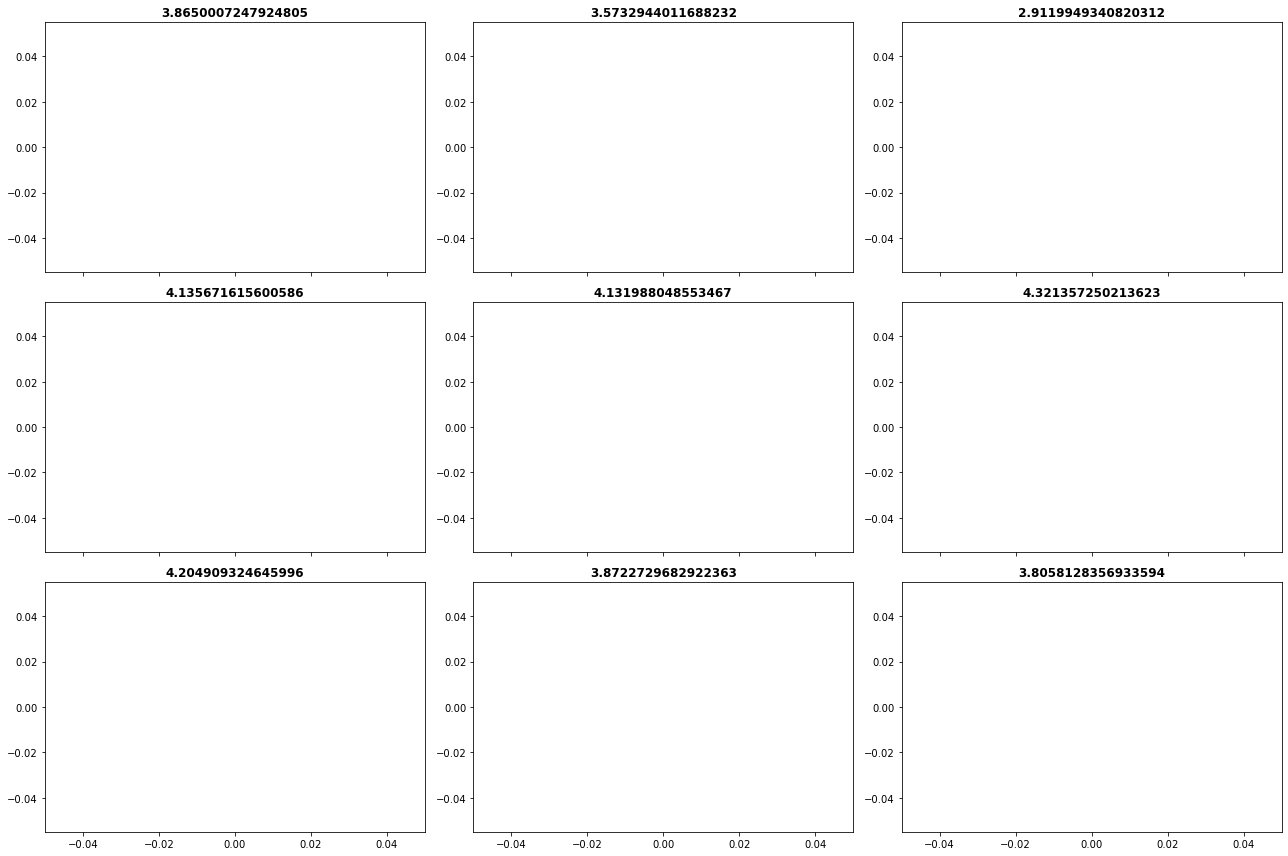

In [161]:
dls.show_batch()

In [175]:
learner = ts_learner(dls, TCN, metrics=[mae, rmse])#, cbs=ShowGraph(),)

In [174]:
learner.opt_func

<function fastai.optimizer.Adam(params, lr, mom=0.9, sqr_mom=0.99, eps=1e-05, wd=0.01, decouple_wd=True)>

In [170]:
learner.dls

In [171]:
learner.dls = dls

In [176]:
learner.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,mae,_rmse,time


ZeroDivisionError: integer division or modulo by zero

In [173]:
dls.loss_func


FlattenedLoss of MSELoss()